In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#This cell takes all the csv files from my google drive and creates 4 DataFrames for each csv file

beneficiary_path='/content/drive/MyDrive/AppliedRoots/Project/Train_Beneficiarydata-1542865627584.csv'
inpatient_path='/content/drive/MyDrive/AppliedRoots/Project/Train_Inpatientdata-1542865627584.csv'
outpatient_path='/content/drive/MyDrive/AppliedRoots/Project/Train_Outpatientdata-1542865627584.csv'
labels_path='/content/drive/MyDrive/AppliedRoots/Project/Train-1542865627584.csv'


beneficiary=pd.read_csv(beneficiary_path)
inpatient=pd.read_csv(inpatient_path)
outpatient=pd.read_csv(outpatient_path)
labels=pd.read_csv(labels_path)

Mounted at /content/drive


# Merging all Datasets

In [ ]:
patients=pd.concat([inpatient,outpatient])        #concatenates inpatient and outpatient dataframe on all the columns
patientDetails=patients.merge(beneficiary,on='BeneID',how='inner')      #merges patient dataframe with beneficiary on Beneficiary ID.
train=patientDetails.merge(labels,on='Provider',how='inner')    #merges previous dataframe with provider lables.
train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,Yes
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,1913-12-01,NaN,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,Yes
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,1922-10-01,NaN,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,Yes
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,1930-07-01,NaN,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,Yes


In [ ]:
train.shape

(558211, 55)

# Calculating Percentage of Null Values across all columns

In [ ]:
train.isnull().sum()/len(train)*100          # prints percentage of null values for each column

BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
Provider                             0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
AdmissionDt                         92.749337
ClmAdmitDiagnosisCode               73.863109
DeductibleAmtPaid                    0.161050
DischargeDt                         92.749337
DiagnosisGroupCode                  92.749337
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                

# Data Preprocessing

In [ ]:
date_cols=["ClaimStartDt","ClaimEndDt","AdmissionDt","DischargeDt","DOB","DOD"]        #converting all date columns from string to datetime datatype
for column in date_cols:
  train[column]=pd.to_datetime(train[column])

In [ ]:
#including both admission day and discharge day as hospitalization for inpatients
train.loc[train["AdmissionDt"].isna()==False,"noDaysAdmit"]= (train["DischargeDt"] - train["AdmissionDt"]).dt.days + 1  
train.loc[train["AdmissionDt"].isna()==True,"noDaysAdmit"]=0                #outpatients will have NaN and so making noDaysAdmit 0 for them

train["noDaysClaim"]=(train["ClaimEndDt"] - train["ClaimStartDt"]).dt.days + 1
#there are no null values in ClaimStartDt and ClaimEndDt

In [ ]:
#Adding new column age(if Date of Death is not given , age is calculated by subtracting DOB from Claim Start Date)
train.loc[train["DOD"].isna()== False , "age"]= round((train['DOD']-train['DOB']).dt.days/365)
train.loc[train["DOD"].isna()== True , "age"]= round((train['ClaimStartDt']-train['DOB']).dt.days/365)

In [ ]:
#Adding new column 'inOut', whether patient is inpatient or outpatient..0-means outpatient , 1 means inpatient
train.loc[train["AdmissionDt"].isna()==True,"inOut"]=0
train.loc[train["AdmissionDt"].isna()==False,"inOut"]=1

In [ ]:
#Adding column 'whetherAlive' whether patient is alive or dead..alive= 1 , dead =0
train.loc[train["DOD"].isna()== True , "whetherAlive"]=1
train.loc[train["DOD"].isna()== False , "whetherAlive"]=0

In [ ]:
#Replacing 2 with 0 in the below columns..0 means patient doesn't have that chronic disease and 1 if patient has that disease
chronic_columns=["ChronicCond_Alzheimer", "ChronicCond_Heartfailure","ChronicCond_KidneyDisease","ChronicCond_Cancer","ChronicCond_ObstrPulmonary",
                 "ChronicCond_Depression","ChronicCond_Diabetes","ChronicCond_IschemicHeart","ChronicCond_Osteoporasis","ChronicCond_rheumatoidarthritis",
                 "ChronicCond_stroke","Gender"]
for column in chronic_columns:
  train[column] = train[column].apply(lambda x: 0 if x == 2 else 1)    #there are no null values in any of these columns


In [ ]:
#Adding new column which is difference b/w claim and hospitalization duration
train['ClaimMinusAdmitDays']=train['noDaysClaim']-train['noDaysAdmit']

In [ ]:
#Replacing 'Y' with 1 in RenalDiseaseIndicator
train['RenalDiseaseIndicator'] = train['RenalDiseaseIndicator'].apply(lambda x: 0 if x == '0' else 1)
train.RenalDiseaseIndicator.value_counts()

0    448363
1    109848
Name: RenalDiseaseIndicator, dtype: int64

In [ ]:
# Creating 4 new dataframes from merged data
train_inpatient=train[train.inOut==1]
train_outpatient=train[train.inOut==0]
train_fraud=train[train.PotentialFraud=="Yes"]
train_normal=train[train.PotentialFraud=="No"]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 61 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           558211 non-null  object        
 1   ClaimID                          558211 non-null  object        
 2   ClaimStartDt                     558211 non-null  datetime64[ns]
 3   ClaimEndDt                       558211 non-null  datetime64[ns]
 4   Provider                         558211 non-null  object        
 5   InscClaimAmtReimbursed           558211 non-null  int64         
 6   AttendingPhysician               556703 non-null  object        
 7   OperatingPhysician               114447 non-null  object        
 8   OtherPhysician                   199736 non-null  object        
 9   AdmissionDt                      40474 non-null   datetime64[ns]
 10  ClmAdmitDiagnosisCode            145899 non-

#EDA

In [ ]:
#Univariate Analysis 

In [ ]:
# Fraction of Fraudulent providers in the merged data.
len(train[train.PotentialFraud == "Yes"])/len(train)

0.3812106891480103

In [ ]:
# https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def twoColumns(figure, column, column_categories,column2,column2_categories):         #This function prints the percentages on each bar if hue is present.
    a = [p.get_height() for p in figure.patches]                                #to get height of each bar
    patch = [p for p in figure.patches]
    for i in range(column_categories):                      
        total = column.value_counts().values[::-1][i]      
        for j in range(column2_categories):
            percentage = str(round(a[j*column_categories + i]*100/total,2))+'%'                                     #calculating percentage for each bar
            x_coord = patch[(j*column_categories + i)].get_x() + patch[(j*column_categories + i)].get_width() / 2   #setting x-coordinate for percentage value
            y_coord = patch[(j*column_categories + i)].get_y() + patch[(j*column_categories + i)].get_height()      #setting y-coordinate for percentage value
            figure.annotate(percentage, (x_coord, y_coord))
    print("Distribution of",column2, "across PotentialFraud")
    plt.show()
    
def singleColumn(figure, column):
    total = len(column)
    for p in figure.patches:
        percentage = str(round(p.get_height()*100/total,2))+'%'                  #calculating percentage for each bar
        x_coord = p.get_x() + p.get_width()/2  #setting x-coordinate for percentage value
        y_coord = p.get_y() + p.get_height()   #setting y-coordinate for percentage value
        figure.annotate(percentage, (x_coord, y_coord),ha='center')
    print("Distribution of",column.name)
    plt.show()

# Distribution of Gender w.r.t response variable

Distribution of Gender across PotentialFraud


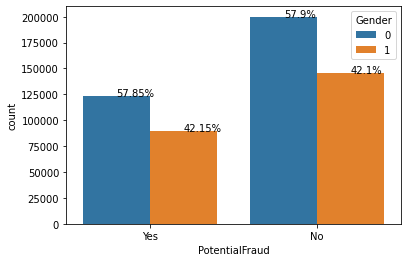

Distribution of Gender


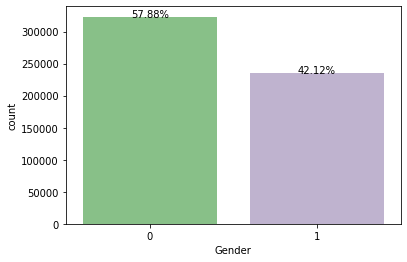

In [ ]:

figure=sns.countplot("PotentialFraud",data=train, hue=train.Gender)
twoColumns(figure,train.PotentialFraud,2,"Gender",2)

figure=sns.countplot(train.Gender,palette='Accent')
singleColumn(figure,train.Gender)




Observation : The Gender ratio is almost similar in both Fraud and Non-Fraud cases. That means,both males and females patient claims are equally probable to be fraudulent, so Gender is not a useful feature in fraud classification.

# In patient vs Out patient count

Distribution of inOut across PotentialFraud


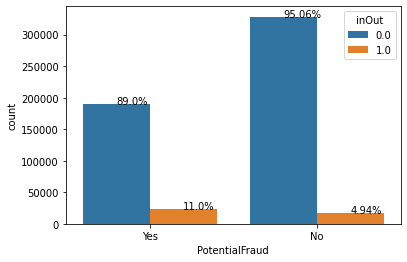

Distribution of inOut


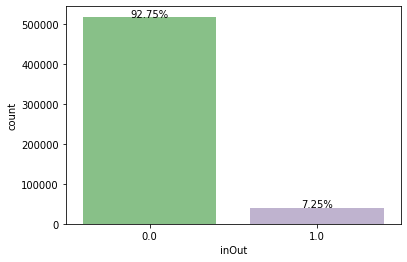

In [ ]:

figure=sns.countplot("PotentialFraud",data=train, hue=train.inOut)
twoColumns(figure,train.PotentialFraud,2,"inOut",2)

figure=sns.countplot(train.inOut,palette='Accent')
singleColumn(figure,train.inOut)




#0-outpatient , 1-inpatient

Observation : Inpatients are only 7.25% out of total patients but in the fraudulent activities , this percentage goes upto 11% if we look only at the fraudulent cases. Hence , inOut can be considered as one of the features in modelling.

# Response variable distribution in labels and merged data

Distribution of PotentialFraud


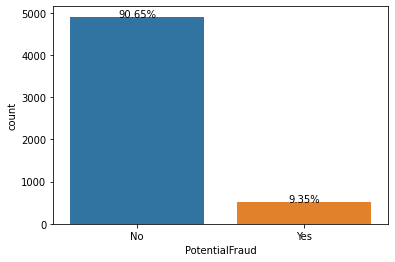

Distribution of PotentialFraud


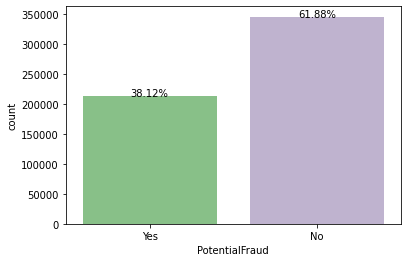

In [ ]:
#Distribution of ProviderFraud in labels data.
figure=sns.countplot("PotentialFraud",data=labels)
singleColumn(figure,labels.PotentialFraud)

#Distribution of ProviderFraud in merged data.
figure=sns.countplot(train.PotentialFraud,palette='Accent')
singleColumn(figure,train.PotentialFraud)

Observation: In the original lables data only 9.35% of providers were fraud but after merging data at the claim level, 38.12% of claims are fraud. That means , even though fraudulent providers are less , they have huge number of claims associated with them.

Distribution of PotentialFraud


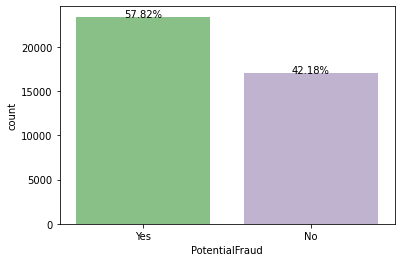

Distribution of PotentialFraud in inpatient data.


In [ ]:
#Distribution of PotentialFraud in inpatient data.
figure=sns.countplot(train_inpatient.PotentialFraud,palette='Accent')
singleColumn(figure,train_inpatient.PotentialFraud)
print('Distribution of PotentialFraud in inpatient data.')

Distribution of PotentialFraud


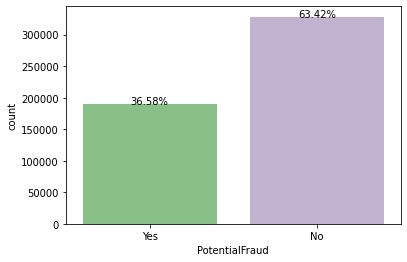

Distribution of PotentialFraud in outpatient data.


In [ ]:
#Distribution of PotentialFraud in outpatient data.
figure=sns.countplot(train_outpatient.PotentialFraud,palette='Accent')
singleColumn(figure,train_outpatient.PotentialFraud)
print('Distribution of PotentialFraud in outpatient data.')

Observation: Inpatients have more fraudulent cases as compared to outpatients Inpatients have more options to make false claims in medicines and procedures.

# Distibution of death status of patients w.r.t response variable

Distribution of whetherAlive across PotentialFraud


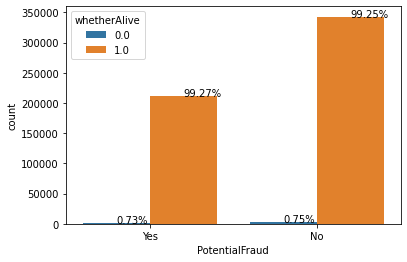

Distribution of whetherAlive


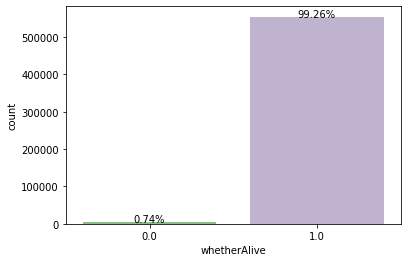

In [ ]:

figure=sns.countplot("PotentialFraud",data=train, hue=train.whetherAlive)
twoColumns(figure,train.PotentialFraud,2,"whetherAlive",2)

figure=sns.countplot(train.whetherAlive,palette='Accent')
singleColumn(figure,train.whetherAlive)



#0--means patient is dead , 1-patient is alive

Observation: There is 0.01% reduction in death patients percentage for fraudulent claims , that means there is slightly more chance for alive patients to have fraud claim than dead ones. But its not that significant to be considered as an immportant feature.

# Distribution of Race w.r.t response variable in Overall,Train and outpatient data

Distribution of Race across PotentialFraud


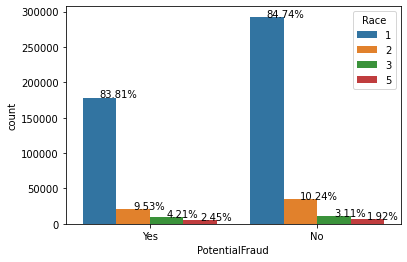

Distribution of Race


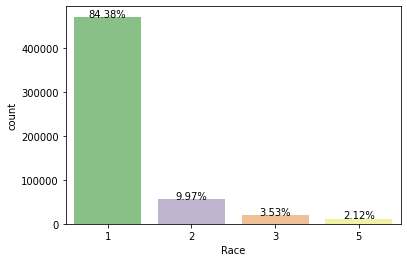

In [ ]:
#Overall Data
figure=sns.countplot("PotentialFraud",data=train, hue=train.Race)
twoColumns(figure,train.PotentialFraud,2,"Race",4)

figure=sns.countplot(train.Race,palette='Accent')
singleColumn(figure,train.Race)


Observation: There is a difference b/w proportion of races in Fraudulent and non-fraud caims especially Race 3 & Race 5 as their percentages increased in fraud claims. We will further check for disribution of race for inpatient and outpatient separately. We can create numeric vectors of race using one-hot encoding

Distribution of Race across PotentialFraud


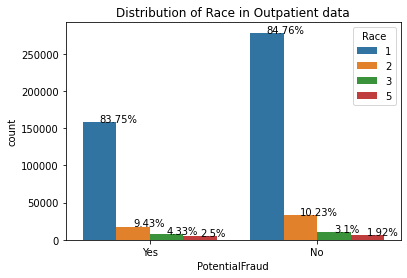

Distribution of Race


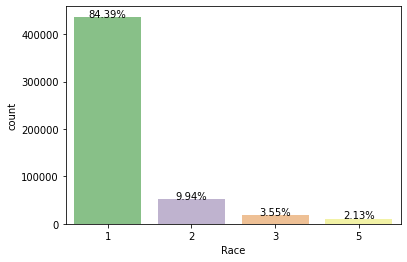

In [ ]:
plt.title('Distribution of Race in Outpatient data')
figure=sns.countplot("PotentialFraud",data=train_outpatient, hue=train_outpatient.Race)
twoColumns(figure,train_outpatient.PotentialFraud,2,"Race",4)

figure=sns.countplot(train_outpatient.Race,palette='Accent')
singleColumn(figure,train_outpatient.Race)

# Proportion of Fraud and Non-Fraud across states in Overall , inpatient and outpatient data

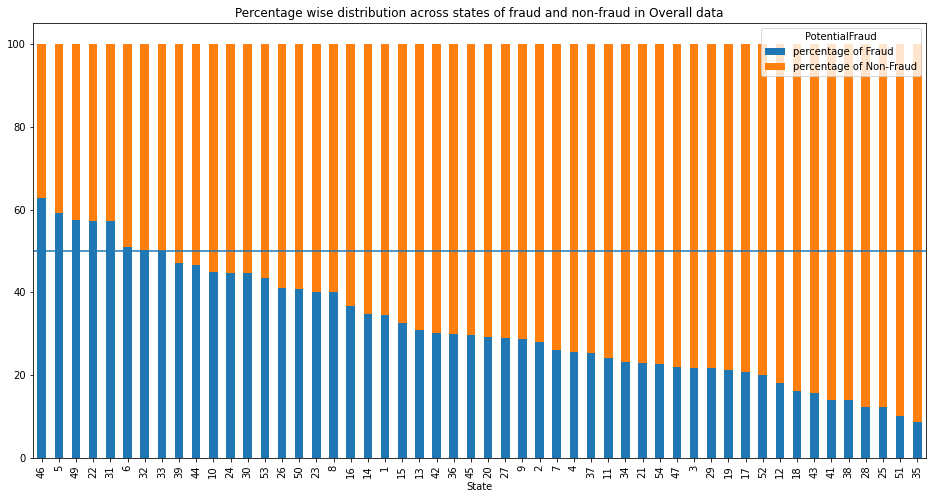

In [ ]:
# Behaviour of state w.r.t fraud and non-fraud in whole train data 
df=train.groupby(['State','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='State',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8))
plt.title('Percentage wise distribution across states of fraud and non-fraud in Overall data')
plt.axhline(y=50)
plt.show()

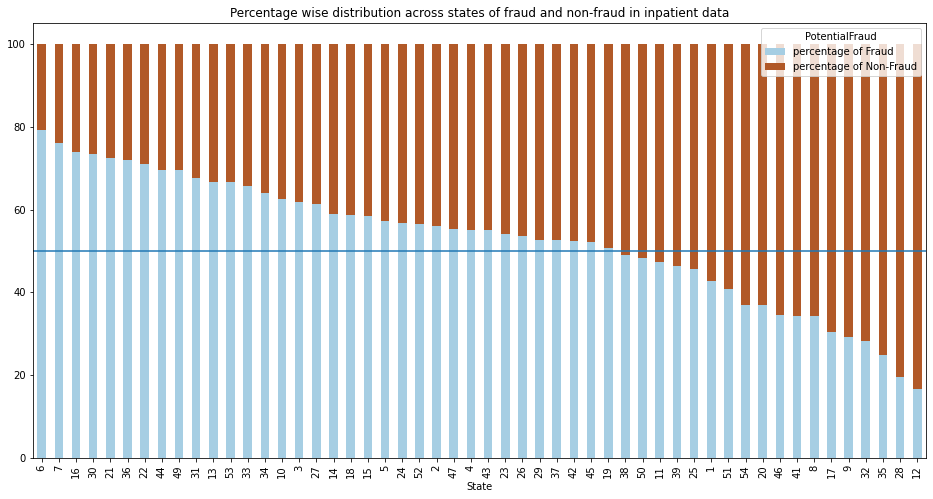

In [ ]:
# Behaviour of states w.r.t fraud and non-fraud in whole inpatient data 
df=train_inpatient.groupby(['State','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='State',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8),colormap='Paired')
plt.title('Percentage wise distribution across states of fraud and non-fraud in inpatient data')
plt.axhline(y=50)
plt.show()

Observation: The states having maximum percebtage of fraudulent cases are different for inpatient and outpatient both. For inpatient , more percentage of claims are fraudulent. 34 states out of 52 have more than 50% of claims as frauduent while in overall data , only 8 are there.

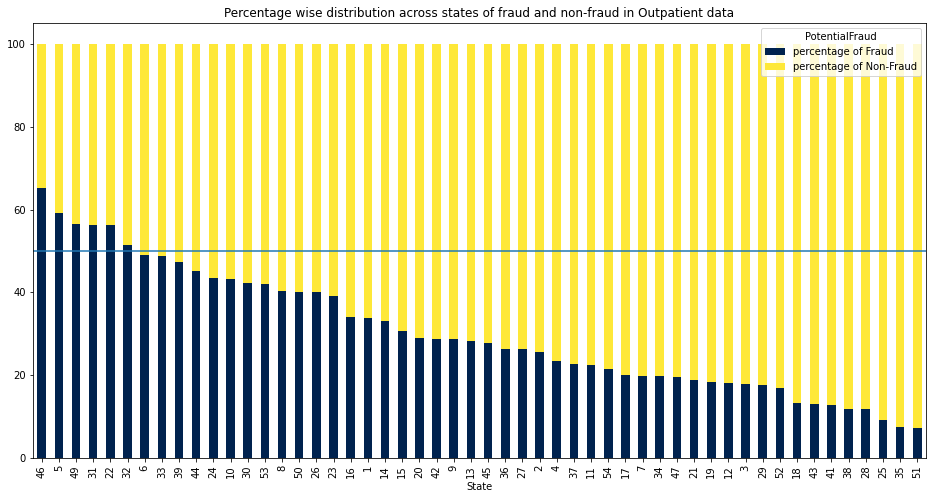

In [ ]:
# Behaviour of states w.r.t fraud and non-fraud in whole outpatient data 
df=train_outpatient.groupby(['State','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='State',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8),colormap='cividis')
plt.axhline(y=50)
plt.title('Percentage wise distribution across states of fraud and non-fraud in Outpatient data')
plt.show()

Observation: Many states have higher percentage of Fraudulent cases which include state 46,5,49,22,31 in overall data. States 6,7,30,21,36, for inpatient data and state 46,5,49,31,22 for outpatient data.

# Proportion of Fraud and Non-Fraud across county in Overall data

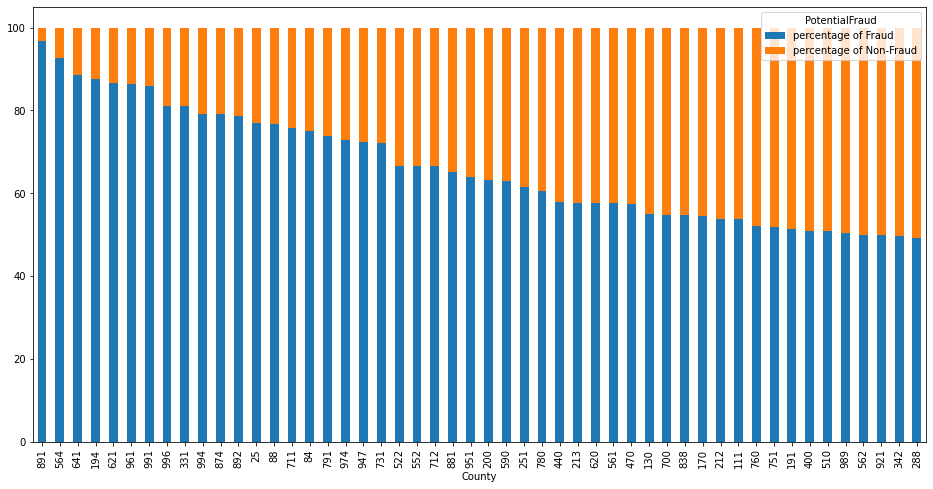

In [ ]:
df=train.groupby(['County','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='County',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.iloc[:50].plot(kind='bar', stacked=True,figsize=(16,8))
plt.show()

In [ ]:
train.County.nunique()

314

USA has total 3200 county but in our dataset , we have around 314 unique county in our dataset and out of 314 , we have plotted only 50 of them. From the plot , we can see that there are 9 county where more than 80% of their claims as fraud. Thus , if a claim is coming from these geograhical regions , there is more chance of being it a fraudulent one.

# Proportion of Fraud and Non-Fraud across difference b/w hospitalization duration and claim duration in Overall data

Text(0.5, 1.0, 'Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in Overall data')

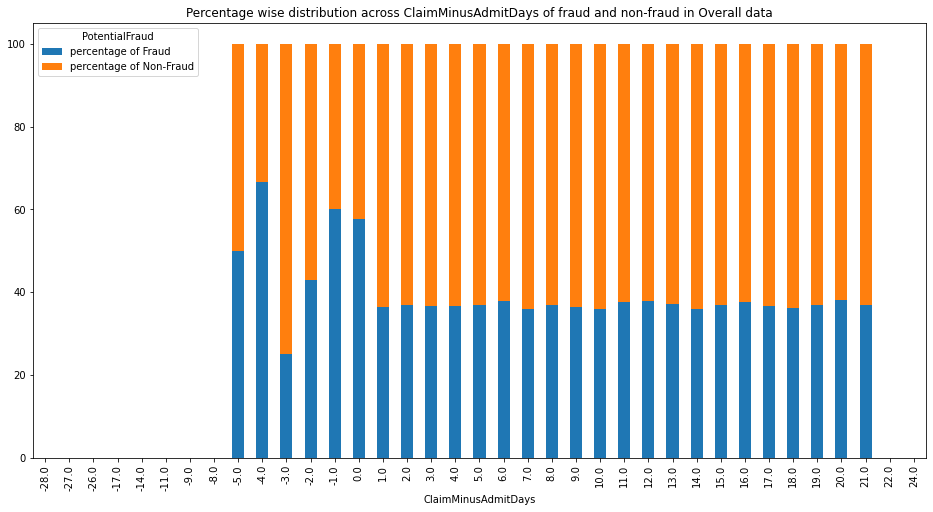

In [ ]:
train['ClaimMinusAdmitDays']=train['noDaysClaim']-train['noDaysAdmit']
df=train.groupby(['ClaimMinusAdmitDays','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='ClaimMinusAdmitDays',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
#df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8))
plt.title('Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in Overall data')

Text(0.5, 1.0, 'Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in inpatient data')

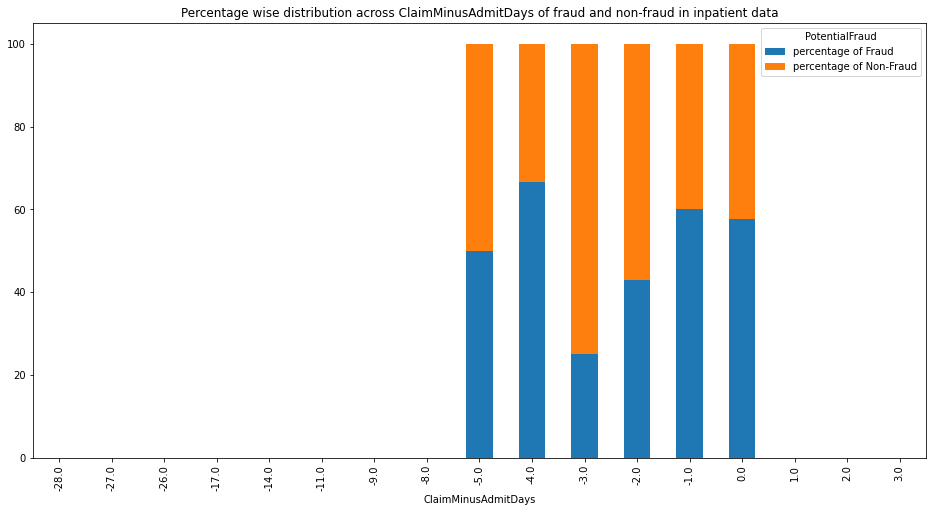

In [ ]:
df=train_inpatient.groupby(['ClaimMinusAdmitDays','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='ClaimMinusAdmitDays',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
#df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8))
plt.title('Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in inpatient data')

In [ ]:
train_inpatient.ClaimMinusAdmitDays.value_counts()

 0.0     40425
 3.0         8
-2.0         7
 1.0         5
-1.0         5
-3.0         4
 2.0         4
-4.0         3
-8.0         2
-5.0         2
-9.0         2
-26.0        2
-11.0        1
-27.0        1
-28.0        1
-17.0        1
-14.0        1
Name: ClaimMinusAdmitDays, dtype: int64

Since, this distribution is highly imbalanced , and we can't generate any insight from the this feature.

Text(0.5, 1.0, 'Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in outpatient data')

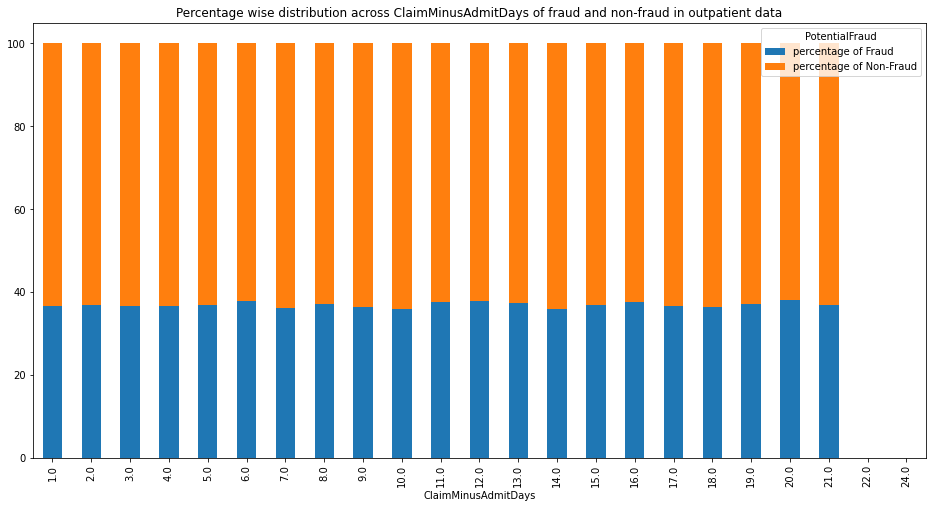

In [ ]:
df=train_outpatient.groupby(['ClaimMinusAdmitDays','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='ClaimMinusAdmitDays',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
#df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(16,8))
plt.title('Percentage wise distribution across ClaimMinusAdmitDays of fraud and non-fraud in outpatient data')

For outpatients , since hospitalization days = 0 , all the values are positive in this case and there is no specific behaviour in the % of claims in each category with respect to claim duration. So , as per outpatient , this is not an important feature.

In [ ]:
train_outpatient.ClaimMinusAdmitDays.value_counts()

#.plot(kind='bar',figsize=(16,8))

1.0     453348
21.0     24312
2.0      11960
3.0       4366
15.0      2735
4.0       2597
8.0       2564
5.0       2238
6.0       1511
10.0      1378
7.0       1306
9.0       1189
17.0      1136
11.0       982
16.0       975
12.0       953
14.0       947
13.0       903
18.0       808
19.0       800
20.0       727
22.0         1
24.0         1
Name: ClaimMinusAdmitDays, dtype: int64

21-day claim period is an exception value as all the other values are very less. We can look further what is the reason for exception behaviour.

#NoOfMonths_PartACov anlysis

Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in overall data')

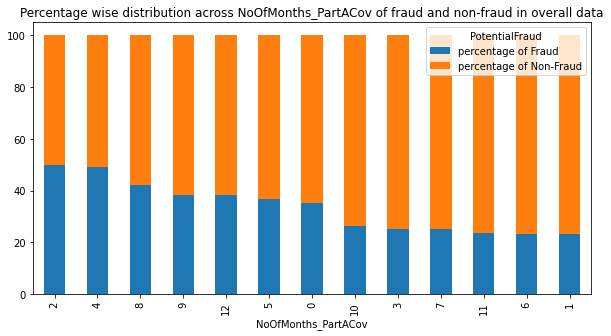

In [ ]:
df=train.groupby(['NoOfMonths_PartACov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartACov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in overall data')

Observation : For values 2,4,8 percentage of fraudulent claims is more in overall data.

Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in inpatient data')

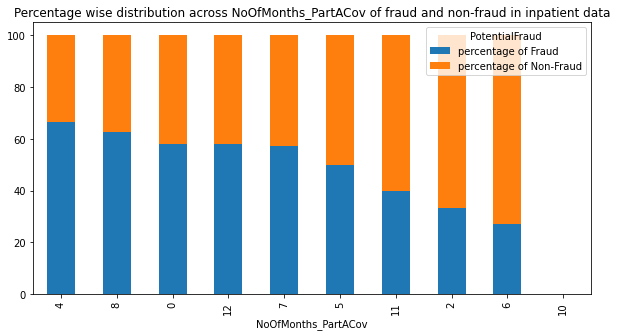

In [ ]:
df=train_inpatient.groupby(['NoOfMonths_PartACov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartACov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in inpatient data')

For inpatients , we have 4,8,0,12,7 with higher percentage of fraudulent claims.

Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in outatient data')

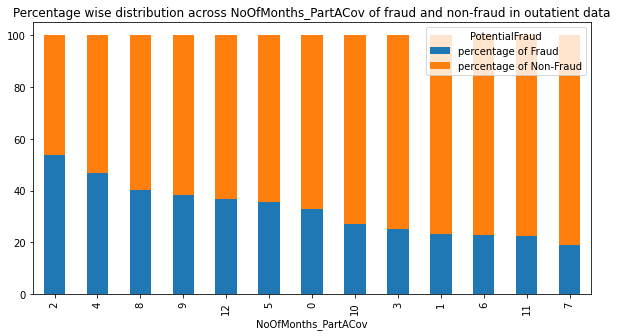

In [ ]:
df=train_outpatient.groupby(['NoOfMonths_PartACov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartACov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartACov of fraud and non-fraud in outatient data')

#NoOfMonths_PartBCov analysis



Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in overall data')

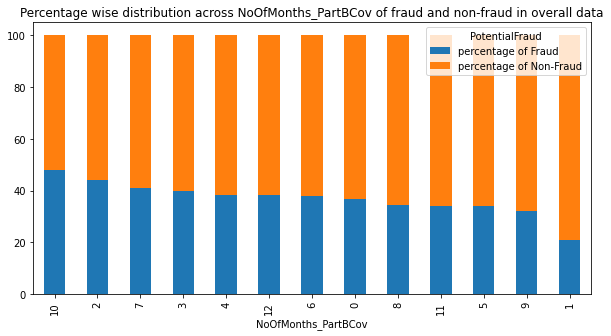

In [ ]:
df=train.groupby(['NoOfMonths_PartBCov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartBCov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in overall data')

Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in inpatient data')

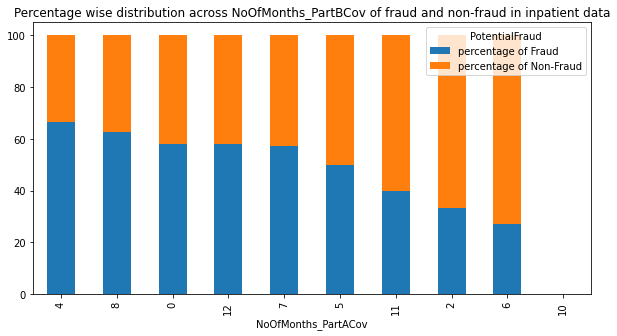

In [ ]:
df=train_inpatient.groupby(['NoOfMonths_PartACov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartACov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in inpatient data')

Text(0.5, 1.0, 'Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in outpatient data')

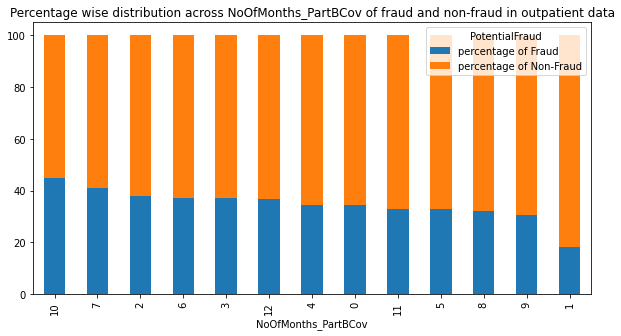

In [ ]:
df=train_outpatient.groupby(['NoOfMonths_PartBCov','PotentialFraud']).size().reset_index()
df_pivoted=df.pivot(columns='PotentialFraud', index='NoOfMonths_PartBCov',values=0)
df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
df_pivoted.drop(['No','Yes'],axis=1,inplace=True)
df_pivoted.sort_values(by=['percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)
#df_pivoted
df_pivoted.plot(kind='bar', stacked=True,figsize=(10,5))
plt.title('Percentage wise distribution across NoOfMonths_PartBCov of fraud and non-fraud in outpatient data')

#Claim Diagnosis Code Analysis

In [ ]:
#Function for plotting Stacked Bar Graphs for Fraud and Non-Fraud across any column categories
def stackedBarGraph(dataframe,column):                                     #takes input as dataframe and sting value of columnn name
  df=dataframe.groupby([column,'PotentialFraud']).size().reset_index()     #resets the index for every row.
  df_pivoted=df.pivot(columns='PotentialFraud', index=column,values=0)     #pivots the table the values of PotentialFraud
  df_pivoted.fillna(0,inplace=True)                                        #fills null values with 0
  df_pivoted['percentage of Fraud']=df_pivoted['Yes']*100/(df_pivoted['No'] +df_pivoted['Yes'])          #claculates % of fraud and non-fraud 
  df_pivoted['percentage of Non-Fraud']=df_pivoted['No']*100/(df_pivoted['No'] +df_pivoted['Yes'])
  df_pivoted['count']= df_pivoted['No'] +df_pivoted['Yes']                                               #calculates count for each category of feature
  df_pivoted.sort_values(by=['count','percentage of Fraud','percentage of Non-Fraud'],ascending=False,inplace=True)     #sorts by count nd % of fraud
  df_pivoted.drop(['No','Yes','count'],axis=1,inplace=True)                                                             #drops other columns
  df_pivoted.iloc[:50].plot(kind='bar', stacked=True,figsize=(10,5))          #plots stacked bar chart for top 50 values
  title=("Percentage wise distribution across "+column+" of fraud and non-fraud in overall data")
  plt.title(title)
  plt.axhline(y=38.12)                              #plots the avearge value of % of fraud claims in overall data which is 38.12%
  #df_pivoted

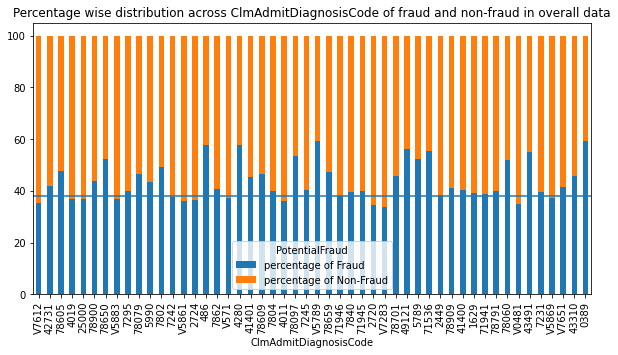

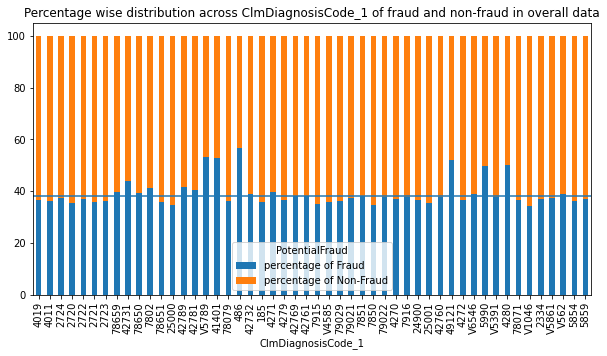

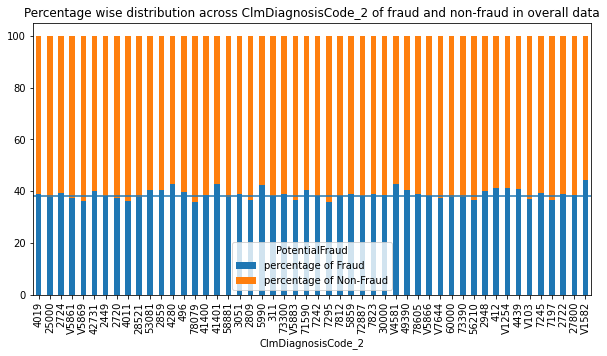

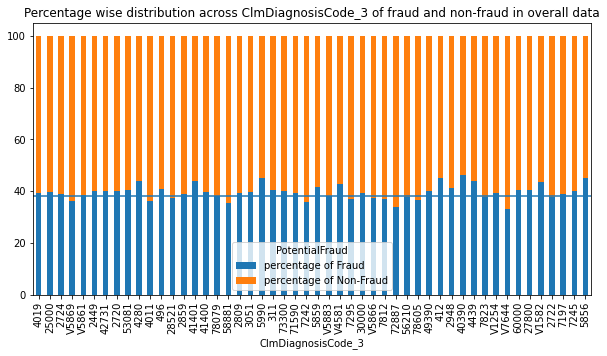

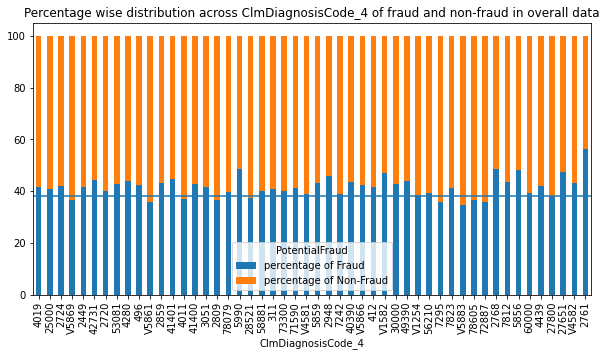

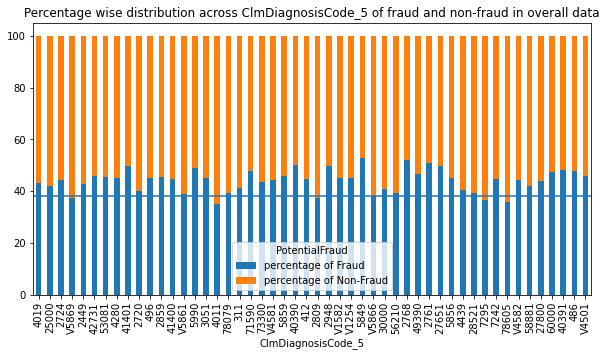

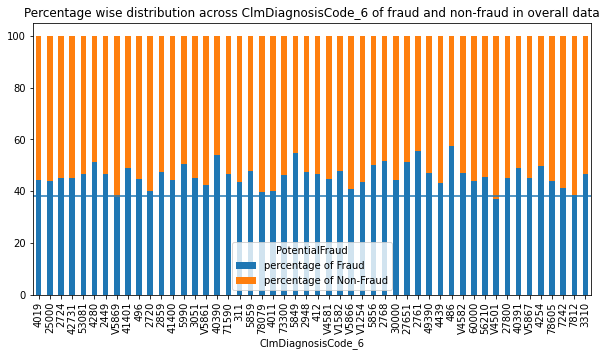

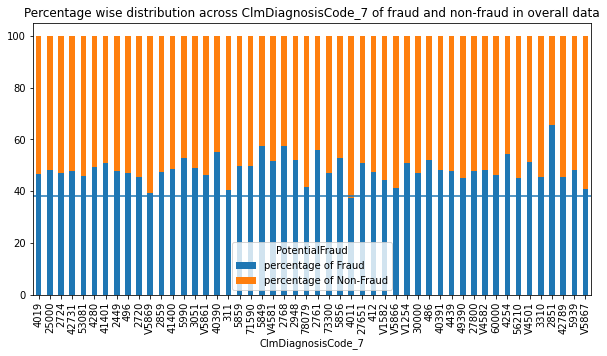

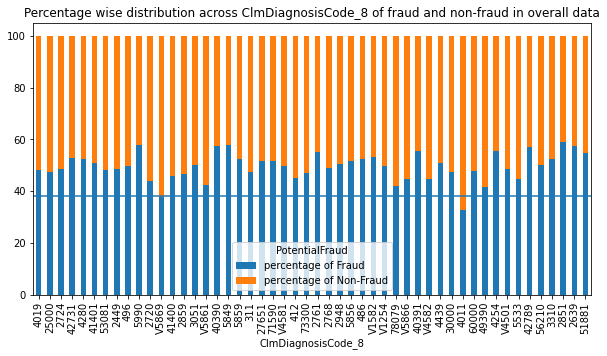

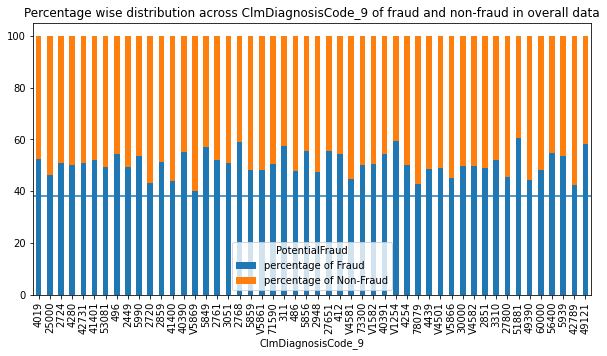

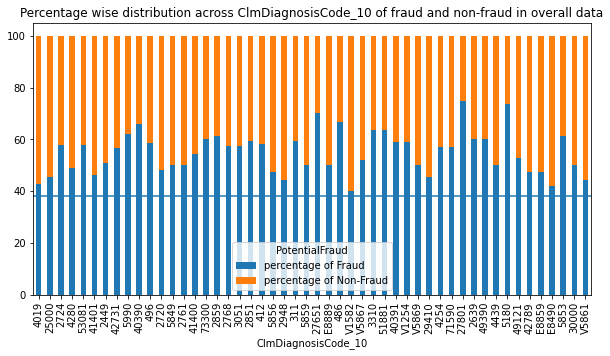

In [ ]:
stackedBarGraph(train,'ClmAdmitDiagnosisCode'),
stackedBarGraph(train,'ClmDiagnosisCode_1'),
stackedBarGraph(train,'ClmDiagnosisCode_2'),
stackedBarGraph(train,'ClmDiagnosisCode_3'),
stackedBarGraph(train,'ClmDiagnosisCode_4'),
stackedBarGraph(train,'ClmDiagnosisCode_5'),
stackedBarGraph(train,'ClmDiagnosisCode_6'),
stackedBarGraph(train,'ClmDiagnosisCode_7'),
stackedBarGraph(train,'ClmDiagnosisCode_8'),
stackedBarGraph(train,'ClmDiagnosisCode_9'),
stackedBarGraph(train,'ClmDiagnosisCode_10')

Observation: there is huge variance in percentage of Fraudulent and Non-Fraudulent claims across various categories of codes and this is an important to consider in further stages. But , there are huge number of categories across each diagnosis codes and these many will be difficult to encode while modelling.

In [ ]:
(len(train['ClmAdmitDiagnosisCode'].value_counts()),
len(train['ClmDiagnosisCode_1'].value_counts()),
len(train['ClmDiagnosisCode_2'].value_counts()),
len(train['ClmDiagnosisCode_3'].value_counts()),
len(train['ClmDiagnosisCode_4'].value_counts()),
len(train['ClmDiagnosisCode_5'].value_counts())
)

(4098, 10450, 5300, 4756, 4359, 3970)

# Claim Procedure Code Analysis

(None,)

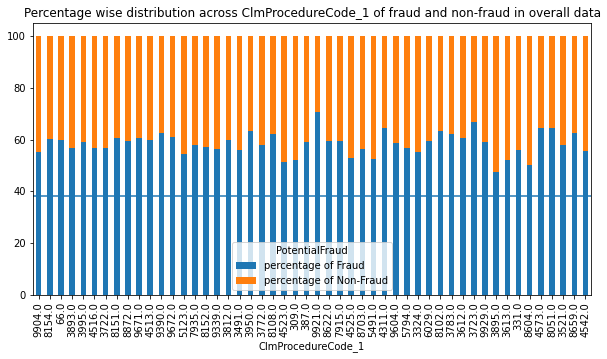

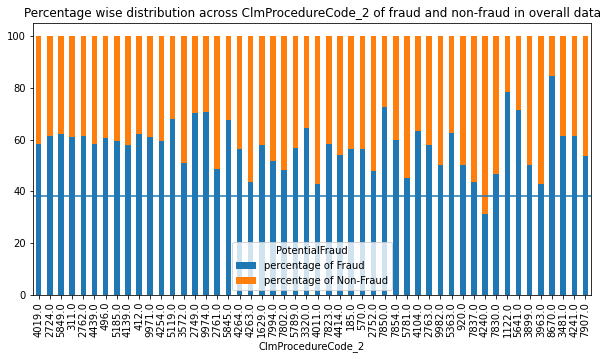

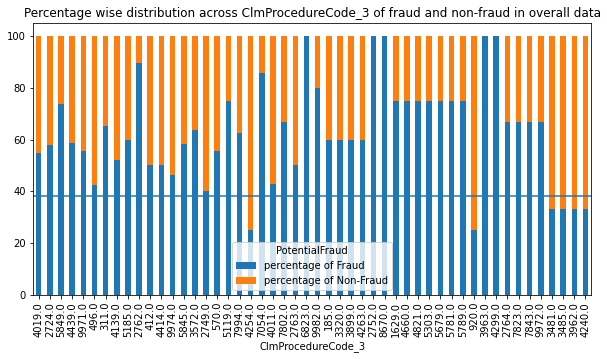

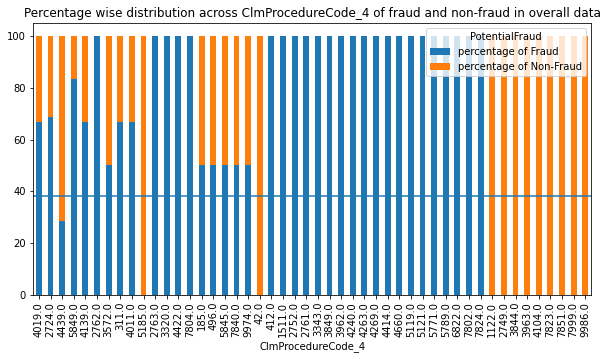

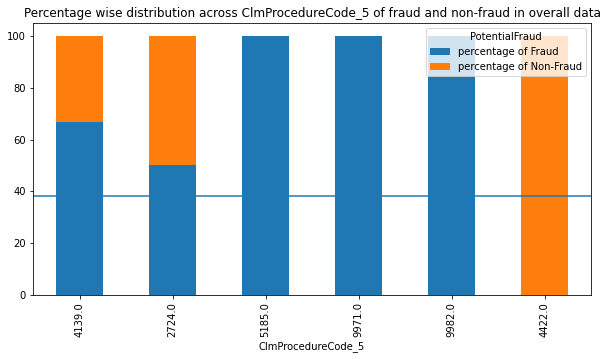

In [ ]:
stackedBarGraph(train,'ClmProcedureCode_1'),
stackedBarGraph(train,'ClmProcedureCode_2'),
stackedBarGraph(train,'ClmProcedureCode_3'),
stackedBarGraph(train,'ClmProcedureCode_4'),
stackedBarGraph(train,'ClmProcedureCode_5'),

Observation: there is huge variance in percentage of Fraudulent and Non-Fraudulent claims across various categories of codes and this is an important to consider in further stages. But , there are huge number of categories across each procedure codes.

# Disease Indicators Analysis

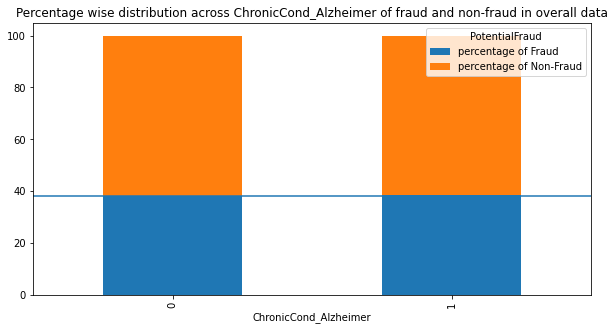

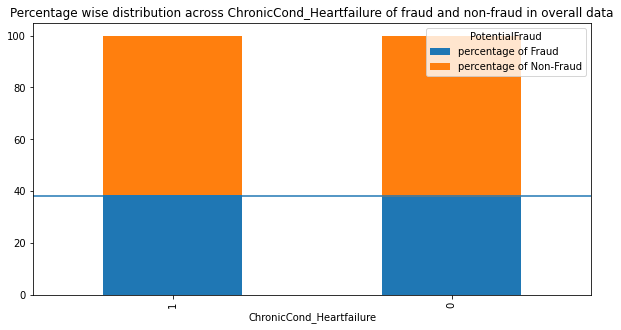

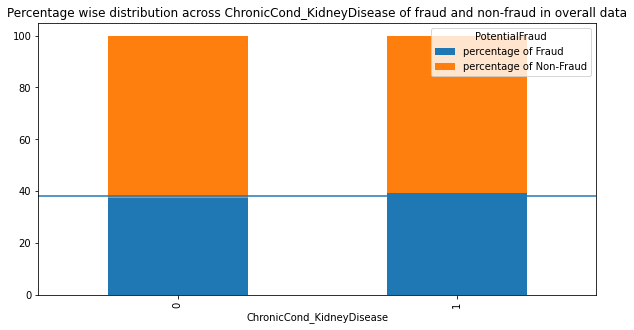

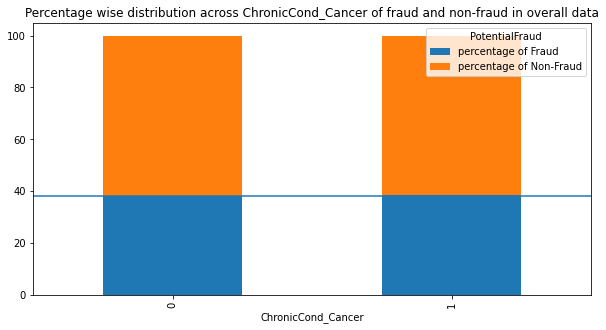

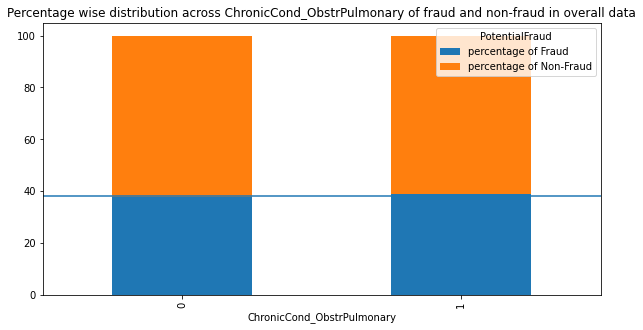

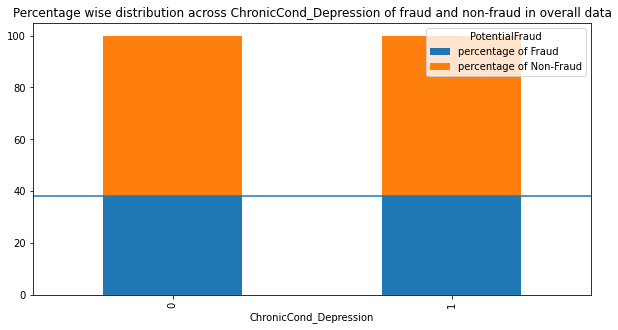

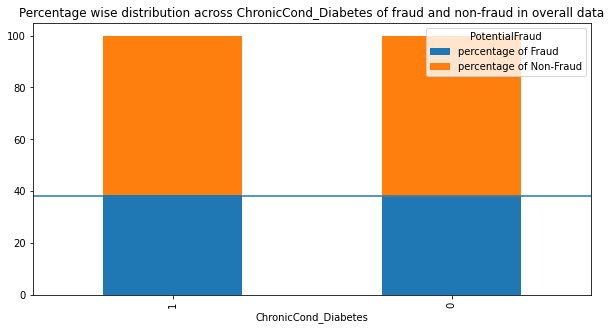

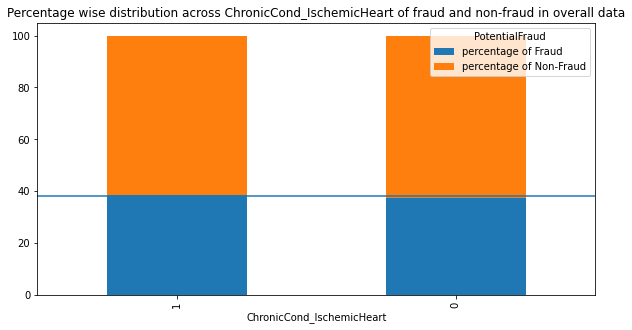

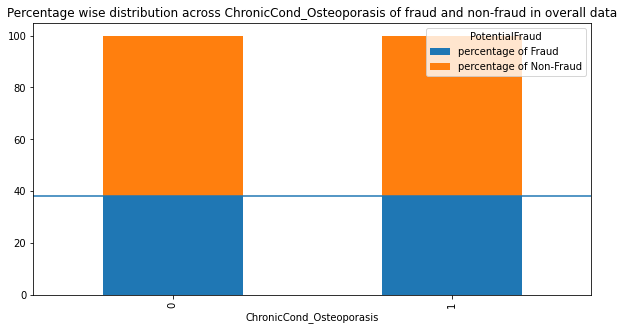

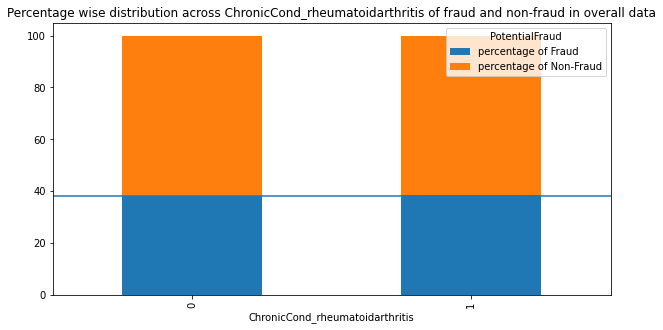

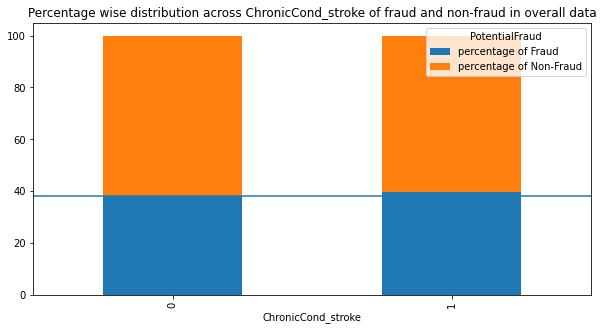

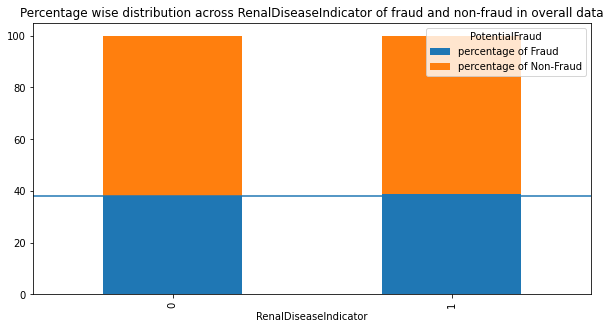

In [ ]:
stackedBarGraph(train,'ChronicCond_Alzheimer'),
stackedBarGraph(train,'ChronicCond_Heartfailure'),
stackedBarGraph(train,'ChronicCond_KidneyDisease'),
stackedBarGraph(train,'ChronicCond_Cancer'),
stackedBarGraph(train,'ChronicCond_ObstrPulmonary'),
stackedBarGraph(train,'ChronicCond_Depression'),
stackedBarGraph(train,'ChronicCond_Diabetes'),
stackedBarGraph(train,'ChronicCond_IschemicHeart'),
stackedBarGraph(train,'ChronicCond_Osteoporasis'),
stackedBarGraph(train,'ChronicCond_rheumatoidarthritis'),
stackedBarGraph(train,'ChronicCond_stroke'),
stackedBarGraph(train,'RenalDiseaseIndicator')


The chronic conditions and renal disease indicators of a patient have almost similar percentage of fraudulent cases irrespective if patient has the disease or not and it is closer to the overall average. Hence , individually these don't contribute much in classification. We will combine all these scores of each patient and see if overall score helps in classification

In [ ]:
#adding column 'PatientRiskValue' that sums all these existing columns and later we can drop them.
chronic_columns=["ChronicCond_Alzheimer", "ChronicCond_Heartfailure","ChronicCond_KidneyDisease","ChronicCond_Cancer","ChronicCond_ObstrPulmonary",
                 "ChronicCond_Depression","ChronicCond_Diabetes","ChronicCond_IschemicHeart","ChronicCond_Osteoporasis","ChronicCond_rheumatoidarthritis",
                 "ChronicCond_stroke","RenalDiseaseIndicator"]

train['PatientRiskValue']=0             #initialising the value to zero at first and later add values of all the columns
for column in chronic_columns:
  train['PatientRiskValue']+=train[column]


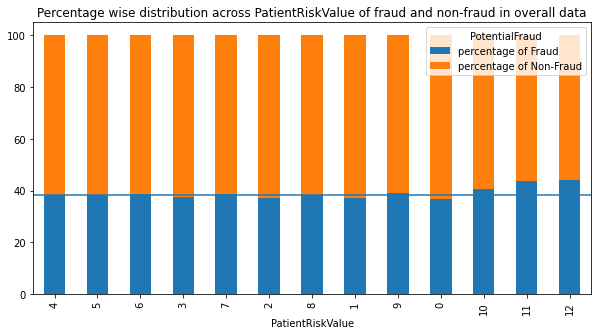

In [ ]:
stackedBarGraph(train,'PatientRiskValue')

After combining the scores also , we can see that patients with risk index 11 & 12 have more chance to be classified as Fraud as compared to other values

In [ ]:
train['PatientRiskValue'].value_counts()

4     77873
5     76464
6     72890
3     69024
7     61611
2     58189
8     44199
1     40268
9     23994
0     21441
10     9754
11     2248
12      256
Name: PatientRiskValue, dtype: int64

# Distribution of Numerical features

Observation for IPAnnualReimbursementAmt , IPAnnualDeductibleAmt , OPAnnualReimbursementAmt , OPAnnualDeductibleAmt , InscClaimAmtReimbursed and DeductibleAmtPaid.It is observed that density of Fraudulent values were more in Inpatient data as compared to Overall and outpatient data for all these features.

# KDE Plots of IPAnnualReimbursementAmt for Fraud and Normal for overall , inpatient and outpatient data.

Text(0.5, 1.0, 'KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in overall data')

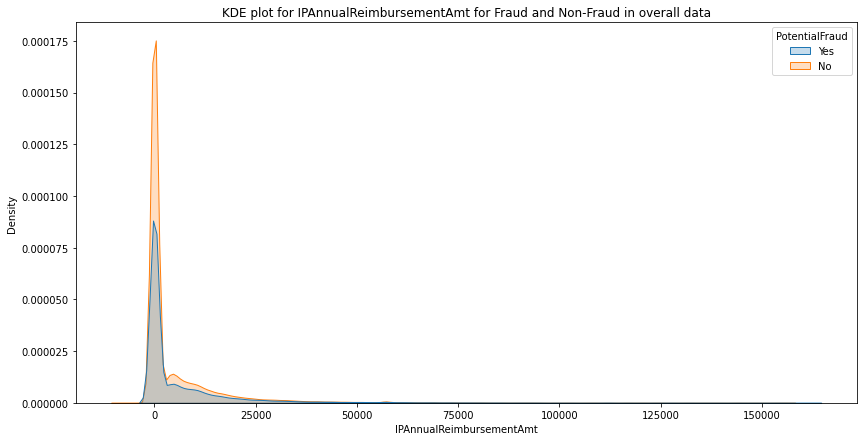

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train['IPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in overall data')

Text(0.5, 1.0, 'KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in inpatient data')

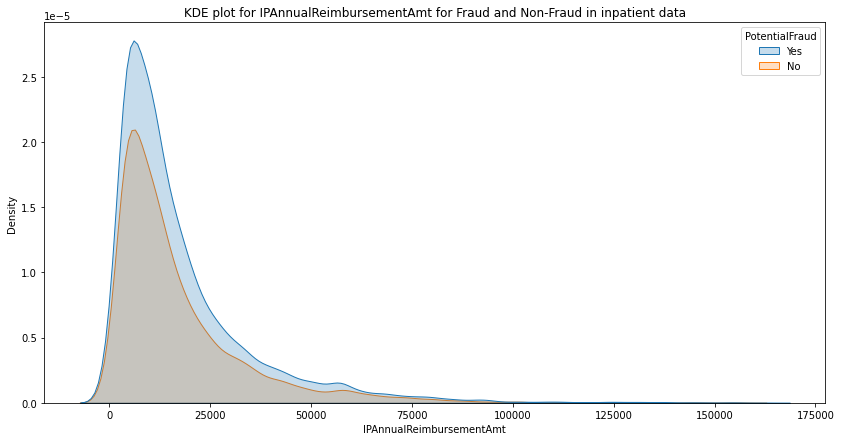

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_inpatient['IPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud']),
plt.title('KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in inpatient data')

Observation: Fraudulent inpatient claims have more no.of values

Text(0.5, 1.0, 'KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in outpatient data')

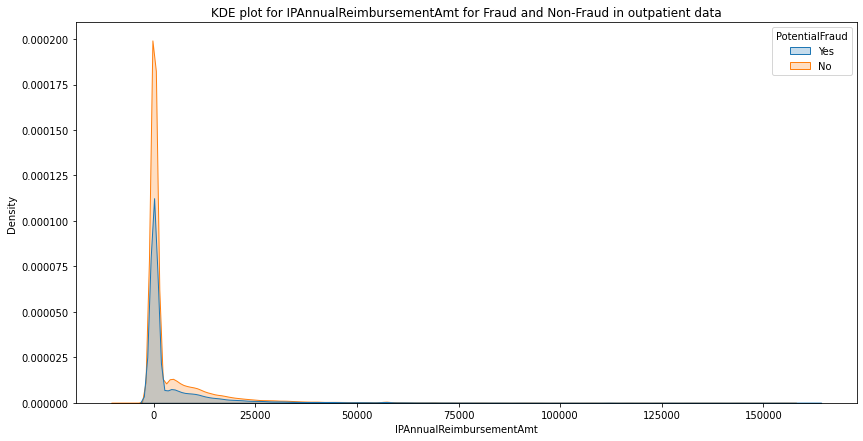

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['IPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for IPAnnualReimbursementAmt for Fraud and Non-Fraud in outpatient data')

# KDE Plots of IPAnnualDeductibleAmt for Fraud and Normal for overall , inpatient and outpatient data.

Text(0.5, 1.0, 'KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in overall data')

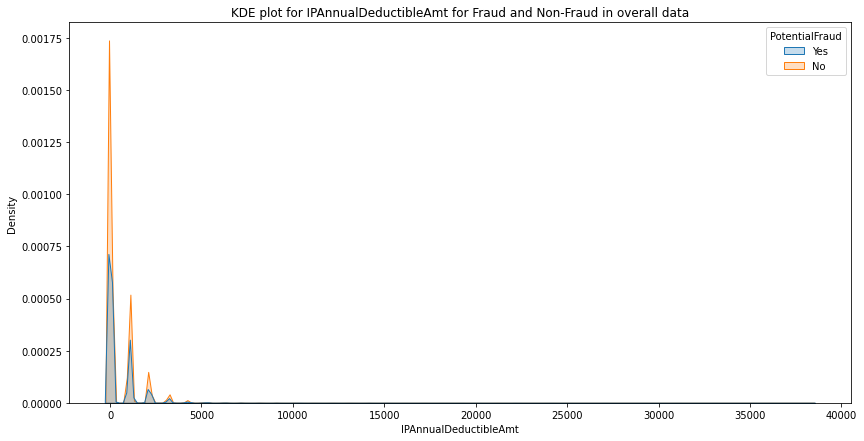

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['IPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in overall data')

Text(0.5, 1.0, 'KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in inpatient data')

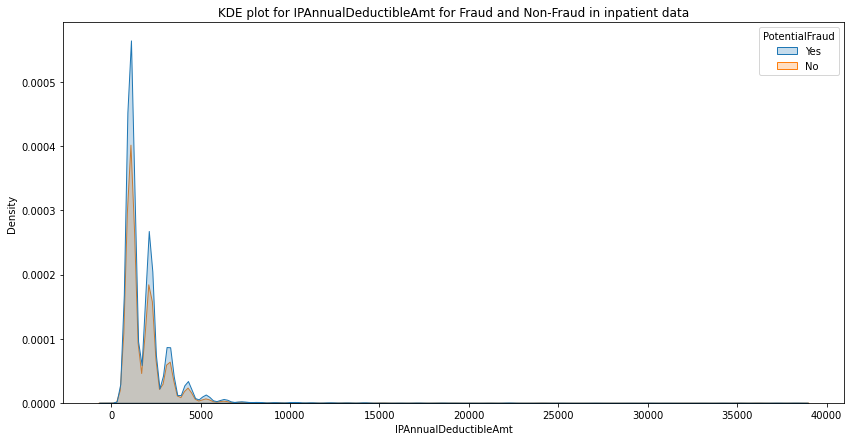

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_inpatient['IPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in inpatient data')

Text(0.5, 1.0, 'KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in outpatient data')

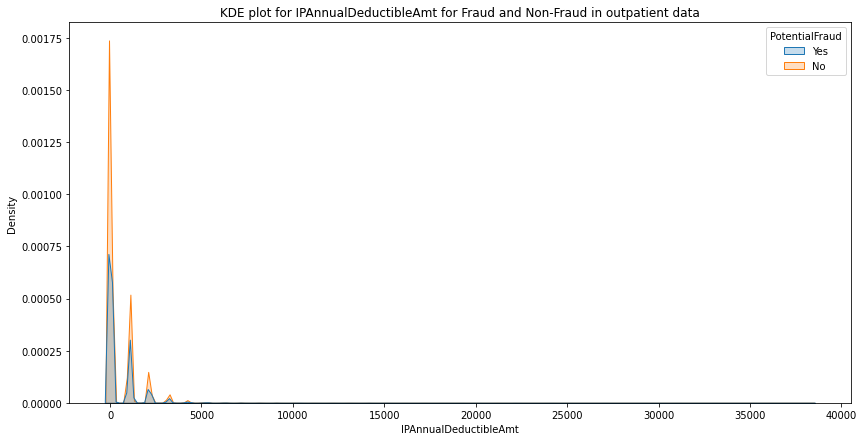

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['IPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for IPAnnualDeductibleAmt for Fraud and Non-Fraud in outpatient data')

# KDE Plots of OPAnnualReimbursementAmt for Fraud and Normal for overall , inpatient and outpatient data.

Text(0.5, 1.0, 'KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in overall data')

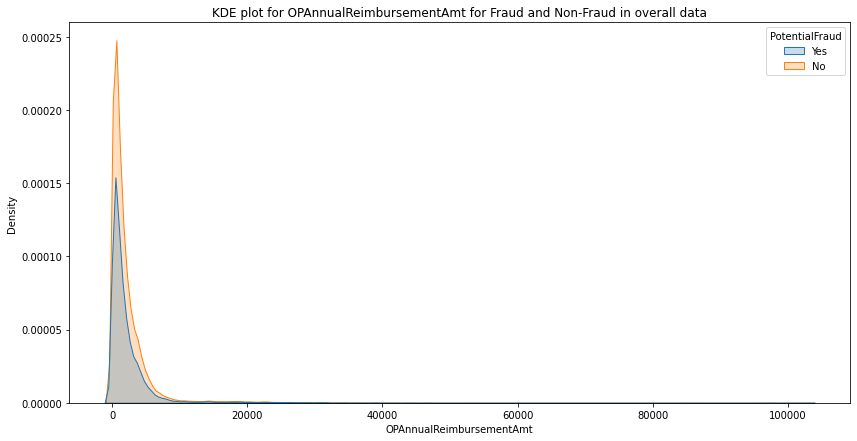

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train['OPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in overall data')

Text(0.5, 1.0, 'KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in inpatient data')

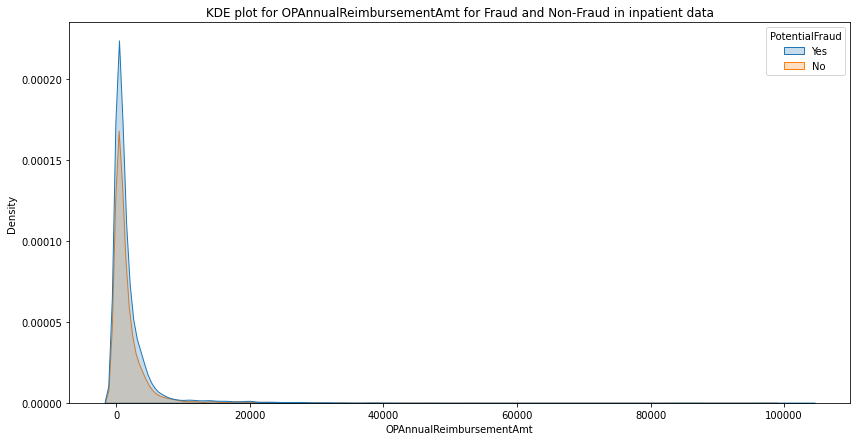

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_inpatient['OPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in inpatient data')

Text(0.5, 1.0, 'KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in outpatient data')

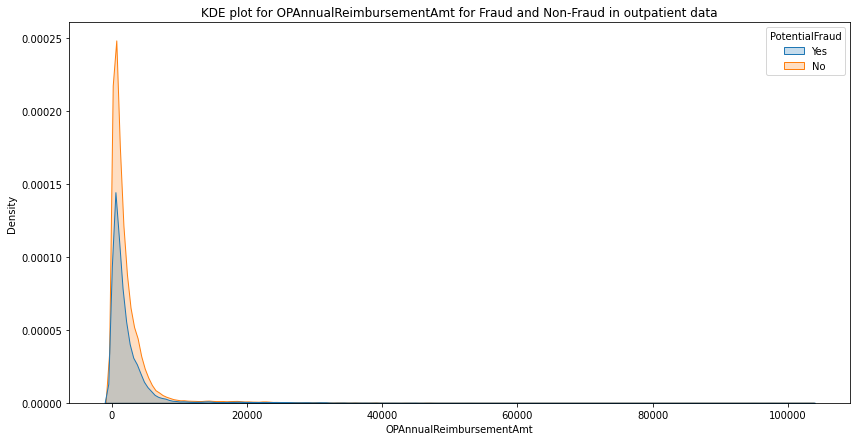

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['OPAnnualReimbursementAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualReimbursementAmt for Fraud and Non-Fraud in outpatient data')

# KDE Plots of OPAnnualDeductibleAmt for Fraud and Normal for overall , inpatient and outpatient data.

Text(0.5, 1.0, 'KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in overall data')

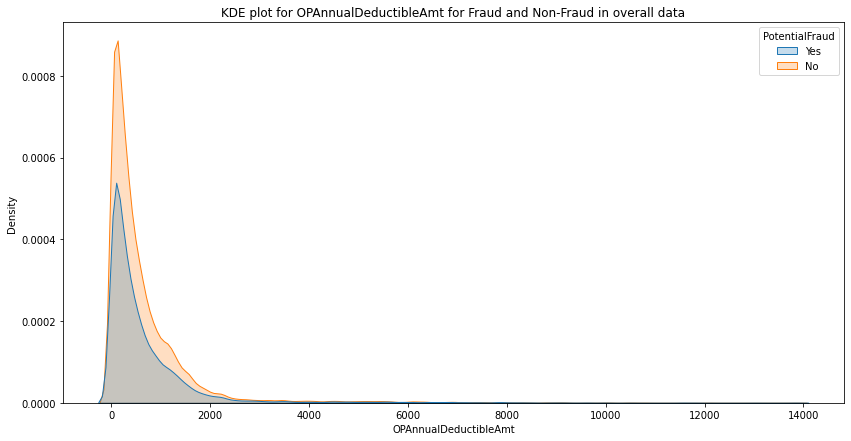

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train['OPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in overall data')

Text(0.5, 1.0, 'KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in inpatient data')

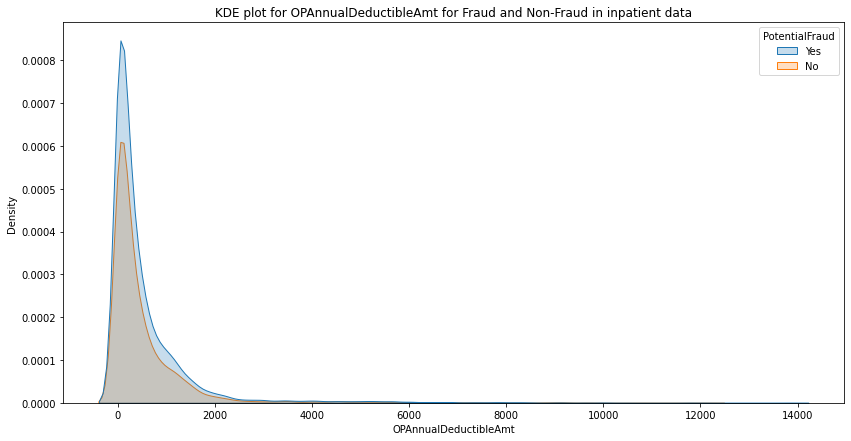

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_inpatient['OPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in inpatient data')

Text(0.5, 1.0, 'KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in outpatient data')

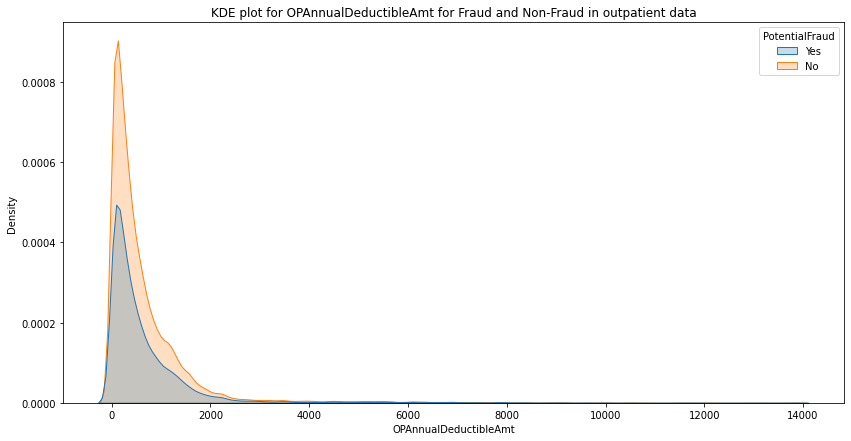

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['OPAnnualDeductibleAmt'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for OPAnnualDeductibleAmt for Fraud and Non-Fraud in outpatient data')

# KDE Plot for InscClaimAmtReimbursed and DeductibleAmtPaid

Text(0.5, 1.0, 'KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in overall data')

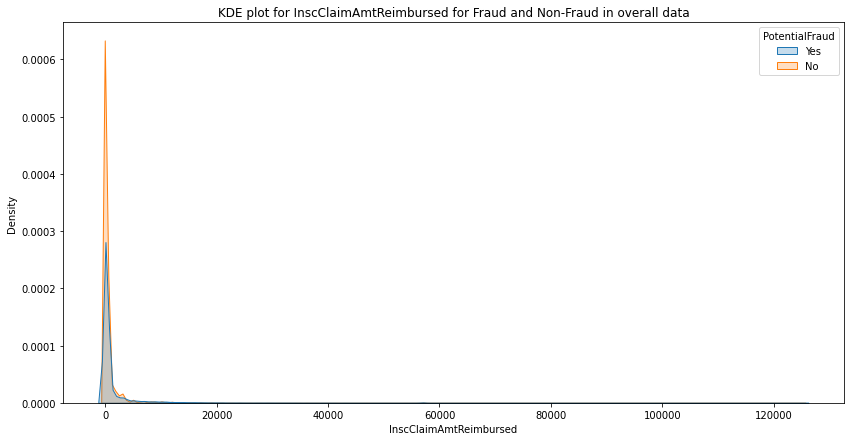

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train['InscClaimAmtReimbursed'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in overall data')

Text(0.5, 1.0, 'KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in inpatient data')

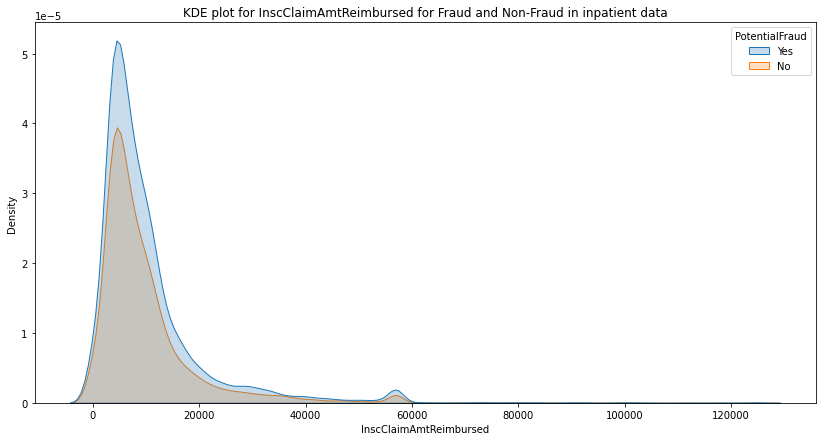

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_inpatient['InscClaimAmtReimbursed'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in inpatient data')

Text(0.5, 1.0, 'KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in outpatient data')

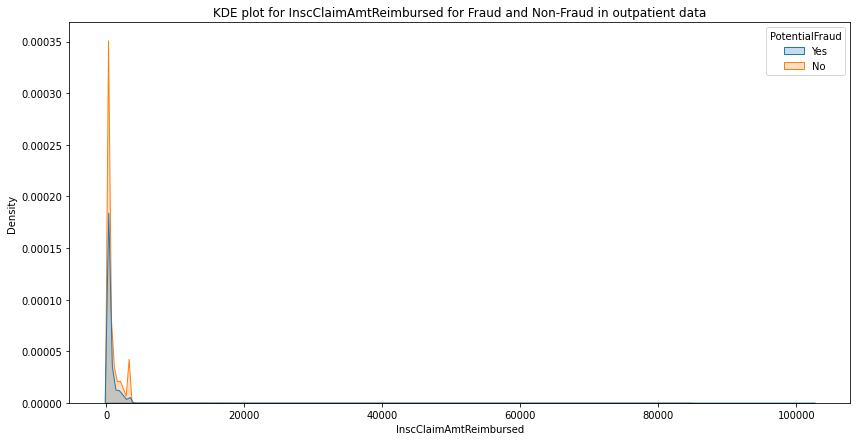

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['InscClaimAmtReimbursed'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for InscClaimAmtReimbursed for Fraud and Non-Fraud in outpatient data')

Text(0.5, 1.0, 'KDE plot for DeductibleAmtPaid for Fraud and Non-Fraud in overall data')

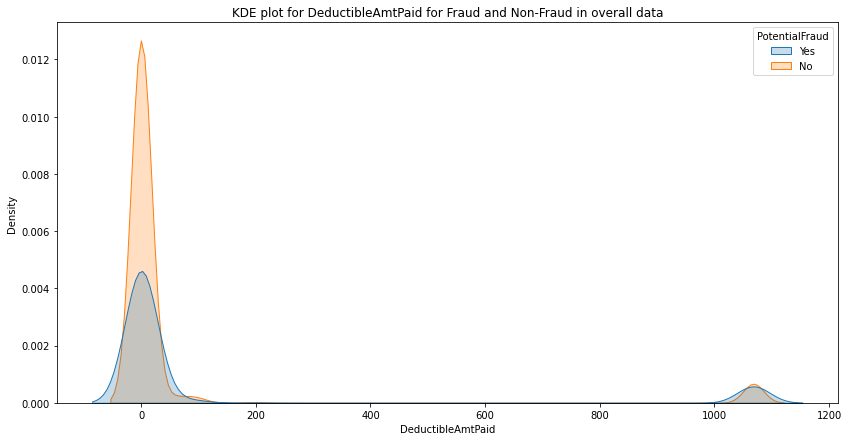

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train['DeductibleAmtPaid'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for DeductibleAmtPaid for Fraud and Non-Fraud in overall data')

In [ ]:
#sns.displot(data=train_inpatient, x="DeductibleAmtPaid", hue="PotentialFraud")
train_inpatient.DeductibleAmtPaid.value_counts()

1068.0    39575
Name: DeductibleAmtPaid, dtype: int64

Observation : The deductible paid by all inpatients is 1068.0 excluding the Nan values. It may be the minimum amount to be paid when a patient is required to be admitted in a hospital in USA.

Text(0.5, 1.0, 'KDE plot for DeductibleAmtPaid for Fraud and Non-Fraud in outpatient data')

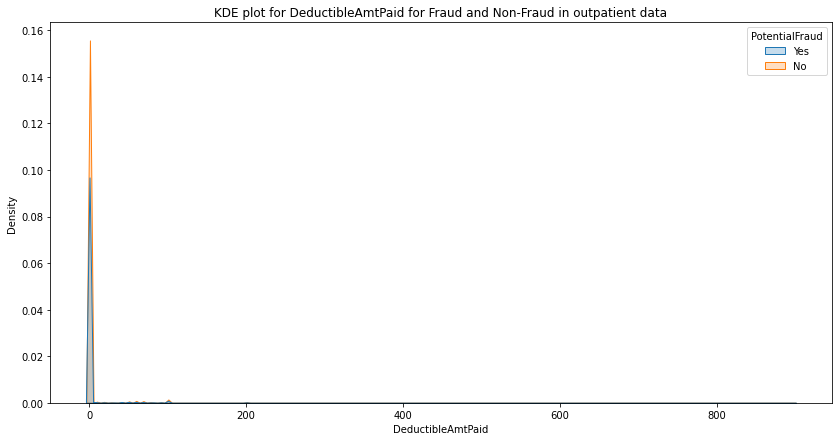

In [ ]:
plt.figure(figsize=(14, 7))
sns.kdeplot(train_outpatient['DeductibleAmtPaid'], shade = True,hue=train['PotentialFraud'])
plt.title('KDE plot for DeductibleAmtPaid for Fraud and Non-Fraud in outpatient data')

Observation for IPAnnualReimbursementAmt , IPAnnualDeductibleAmt , OPAnnualReimbursementAmt , OPAnnualDeductibleAmt , InscClaimAmtReimbursed and DeductibleAmtPaid.It is observed that density of Fraudulent values were more in Inpatient data as compared to Overall and outpatient data for all these features.

# Bivariate Analysis

# Scatter Plot b/w InscClaimAmtReimbursed and DeductibleAmtPaid

Text(0.5, 1.0, 'InscClaimAmtReimbursed vs DeductibleAmtPaid')

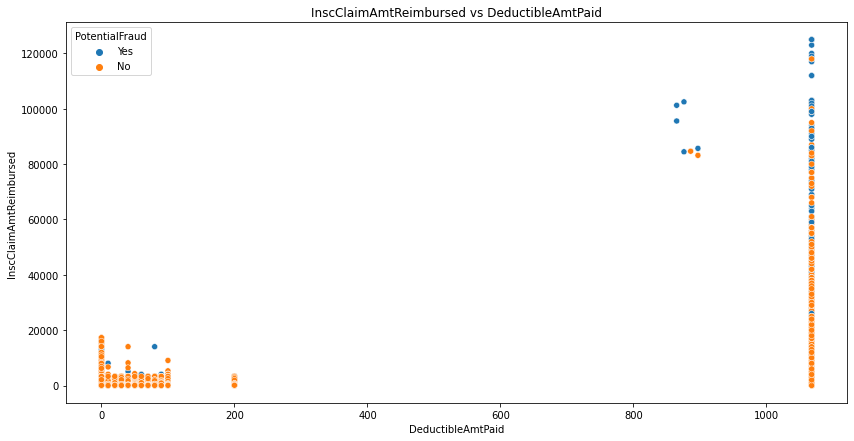

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='InscClaimAmtReimbursed',x='DeductibleAmtPaid',data=train,hue='PotentialFraud')
plt.title('InscClaimAmtReimbursed vs DeductibleAmtPaid')

Observation: For inpatients , DeductibleAmtpAid is 1068 only. So , for inpatients when InscClaimAmtReimbursed is more than 100000 , there is more chance of it being fraud.

Text(0.5, 1.0, 'IPAnnualReimbursementAmt vs IPAnnualDeductibleAmt')

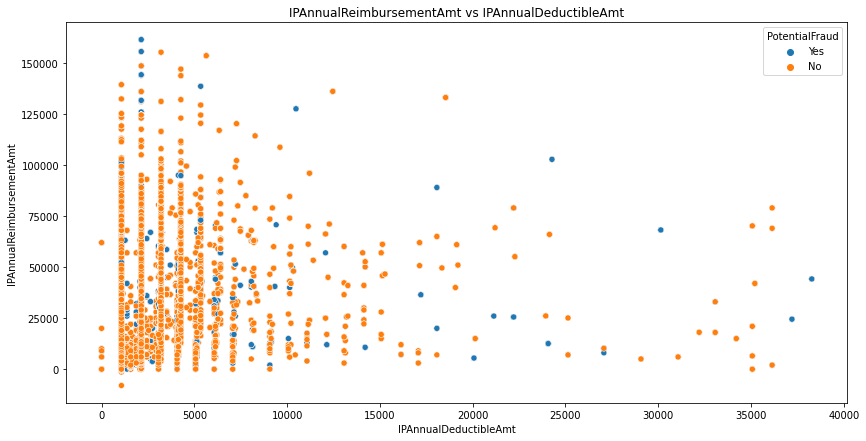

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='IPAnnualReimbursementAmt',x='IPAnnualDeductibleAmt',data=train,hue='PotentialFraud')
plt.title('IPAnnualReimbursementAmt vs IPAnnualDeductibleAmt')

Observation: There is no specific pattern present in plot which can help us classify Fraud and non-Fraud.

Text(0.5, 1.0, 'OPAnnualReimbursementAmt vs OPAnnualDeductibleAmt')

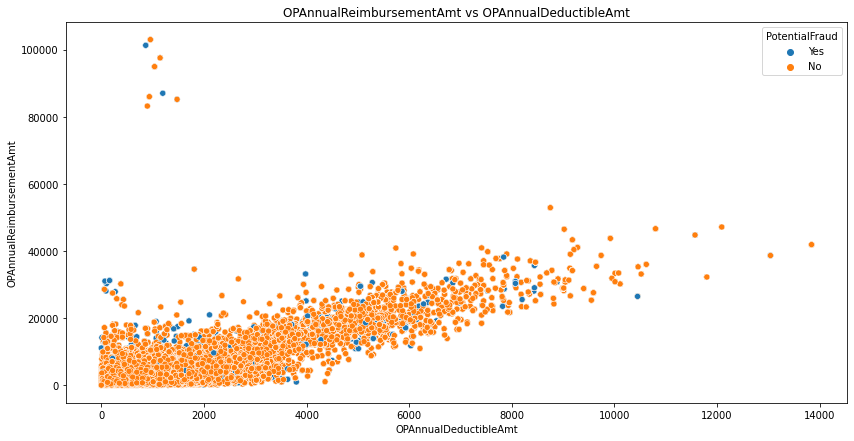

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='OPAnnualReimbursementAmt',x='OPAnnualDeductibleAmt',data=train,hue='PotentialFraud')
plt.title('OPAnnualReimbursementAmt vs OPAnnualDeductibleAmt')

Observation: There is no specific pattern present in plot which can help us classify Fraud and non-Fraud. But one thing is observed that for outpatients , there is linear behavious b/w Reimbursed amt and deductible paid.

In [ ]:
#Adding 2 new columns , TotalAnnualReimbursementAmt and TotalAnnualDeductibleAmt
train['TotalAnnualReimbursementAmt']=train['IPAnnualReimbursementAmt'] + train['OPAnnualReimbursementAmt']
train['TotalAnnualDeductibleAmt']=train['IPAnnualDeductibleAmt'] + train['OPAnnualDeductibleAmt']

#Updating previous dataframes
train_inpatient=train[train.inOut==1]
train_outpatient=train[train.inOut==0]
train_fraud=train[train.PotentialFraud=="Yes"]
train_normal=train[train.PotentialFraud=="No"]

Text(0.5, 1.0, 'TotalAnnualReimbursementAmt vs TotalAnnualDeductibleAmt')

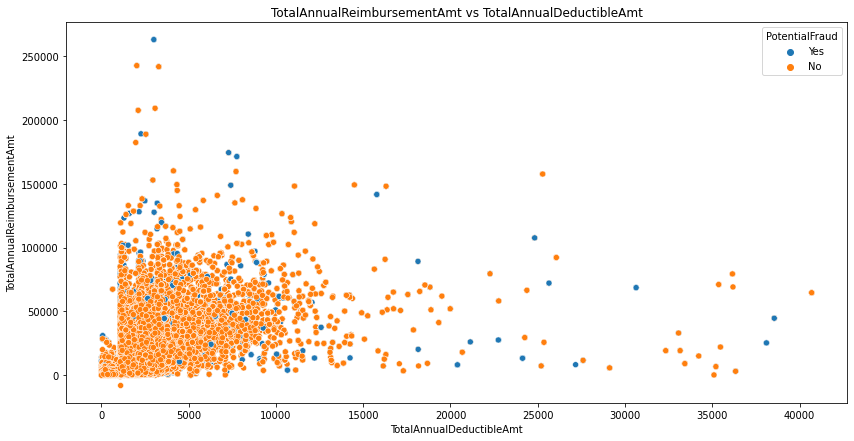

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='TotalAnnualReimbursementAmt',x='TotalAnnualDeductibleAmt',data=train,hue='PotentialFraud')
plt.title('TotalAnnualReimbursementAmt vs TotalAnnualDeductibleAmt')

Observation: There is no specific pattern present in plot which can help us classify Fraud and non-Fraud.

Text(0.5, 1.0, 'InscClaimAmtReimbursed vs TotalAnnualReimbursementAmt')

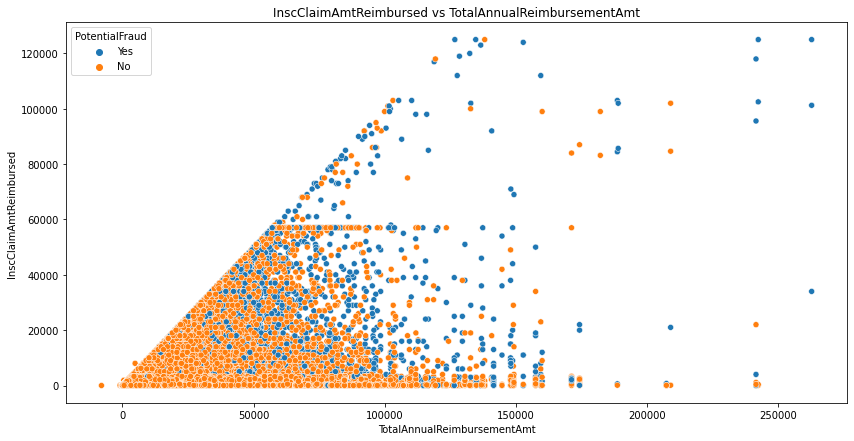

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='InscClaimAmtReimbursed',x='TotalAnnualReimbursementAmt',data=train,hue='PotentialFraud')
plt.title('InscClaimAmtReimbursed vs TotalAnnualReimbursementAmt')

OBservation: If the TotalAnnualReimbursementAmt is greater than 100000 for a patient and ClaimAmtReimbursed is 20000 , there is higher chance of it being Fraud.

Text(0.5, 1.0, 'InscClaimAmtReimbursed vs TotalAnnualDeductibleAmt')

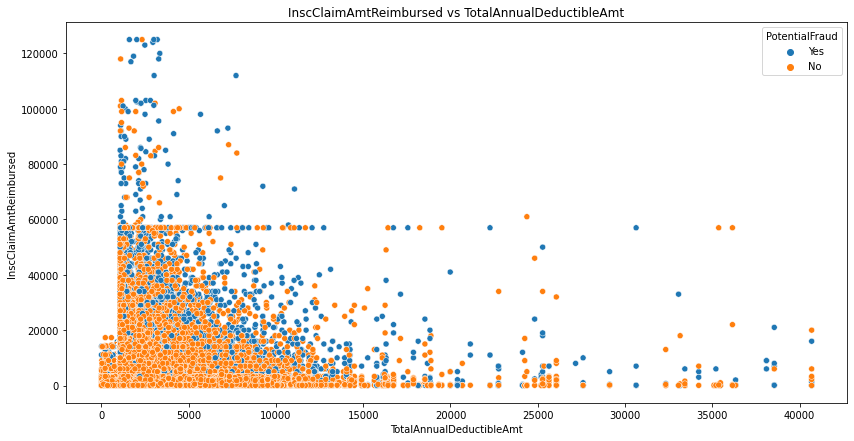

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(y='InscClaimAmtReimbursed',x='TotalAnnualDeductibleAmt',data=train,hue='PotentialFraud')
plt.title('InscClaimAmtReimbursed vs TotalAnnualDeductibleAmt')

Observation: If the InscClaimAmtReimbursed is more than 60000 , there is more chance of Fraudulent transaction. Also , if InscClaimAmtReimbursed is b/w 20000 to 60000 and TotalAnnualDeductibleAmt is greater than 100000 , then also , more chance of Fraudulent is there.

# Physicians Columns

In [ ]:
train.AttendingPhysician.value_counts()

PHY330576    2534
PHY350277    1628
PHY412132    1321
PHY423534    1223
PHY314027    1200
             ... 
PHY327708       1
PHY335561       1
PHY431671       1
PHY311656       1
PHY398729       1
Name: AttendingPhysician, Length: 82063, dtype: int64

This is the proportion of Fraud and Non-Fraud of Attending Physicians in decreasing order of no. of claims


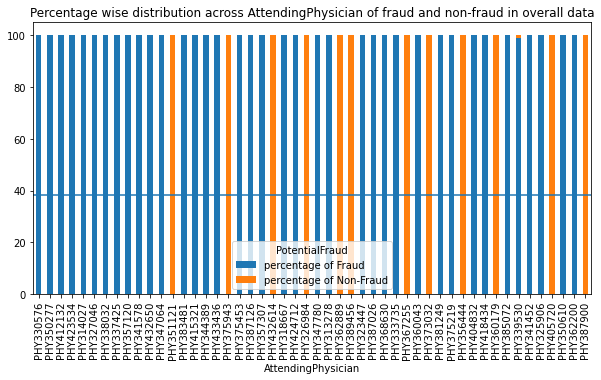

In [ ]:
stackedBarGraph(train,'AttendingPhysician')
print('This is the proportion of Fraud and Non-Fraud of Attending Physicians in decreasing order of no. of claims')

Observation : It is observed that 38 out of 50 Attending Physicians having maximum no . of claims have 100 % Fraud claims. Rest have 0% Fraud claims. So, AttendingPhysician is one of the most important feature for our clasification task.

In [ ]:
train.OperatingPhysician.value_counts()

PHY330576    424
PHY424897    293
PHY314027    256
PHY423534    250
PHY357120    249
            ... 
PHY340038      1
PHY352504      1
PHY427187      1
PHY386877      1
PHY342371      1
Name: OperatingPhysician, Length: 35315, dtype: int64

This is the proportion of Fraud and Non-Fraud of Operating Physicians in decreasing order of no. of claims


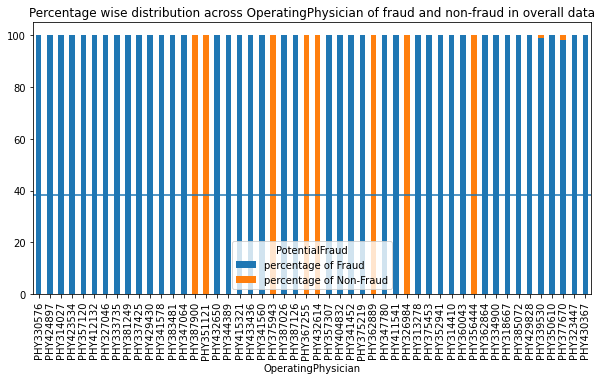

In [ ]:
stackedBarGraph(train,'OperatingPhysician')
print('This is the proportion of Fraud and Non-Fraud of Operating Physicians in decreasing order of no. of claims')

Observation : It is observed that 42 out of 50 Attending Physicians having maximum no . of claims have 100 % Fraud claims. Rest have 0 % Fraud claims. So, OperatingPhysician is one of the most important feature for our clasification task.

In [ ]:
train.OtherPhysician.value_counts()

PHY412132    1247
PHY341578    1098
PHY338032    1070
PHY337425    1041
PHY347064     806
             ... 
PHY331589       1
PHY380670       1
PHY391455       1
PHY395203       1
PHY398729       1
Name: OtherPhysician, Length: 46457, dtype: int64

This is the proportion of Fraud and Non-Fraud of Other Physicians in decreasing order of no. of claims


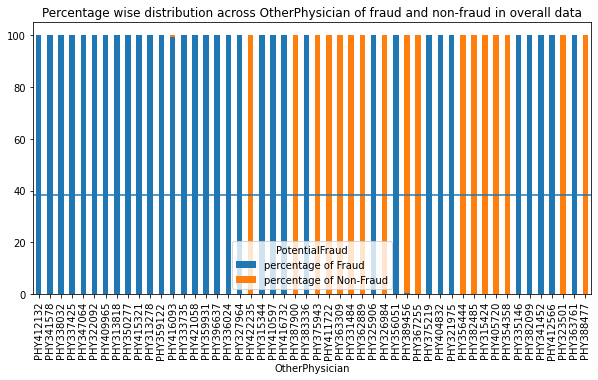

In [ ]:
stackedBarGraph(train,'OtherPhysician')
print('This is the proportion of Fraud and Non-Fraud of Other Physicians in decreasing order of no. of claims')

Observation: Same behaviour is seen in Other Physician as it was in previous two. But in this, the number of non-fraud physicians are more in top -physicians. This is also an important feature in classification.

In [ ]:
train.BeneID.value_counts()  #There are total 138556 unique number of beneficiary 

BENE118316    29
BENE42721     29
BENE59303     29
BENE36330     28
BENE44241     28
              ..
BENE156796     1
BENE138131     1
BENE133100     1
BENE92098      1
BENE47888      1
Name: BeneID, Length: 138556, dtype: int64

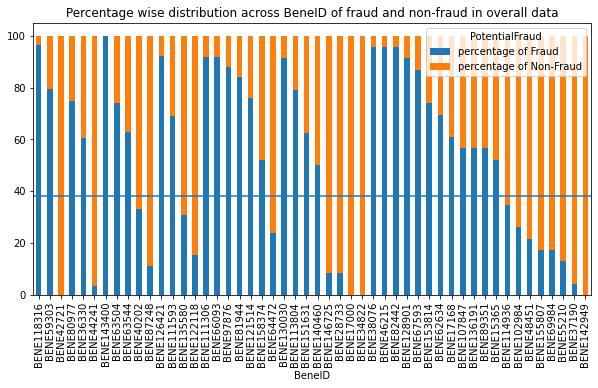

In [ ]:
stackedBarGraph(train,'BeneID') 

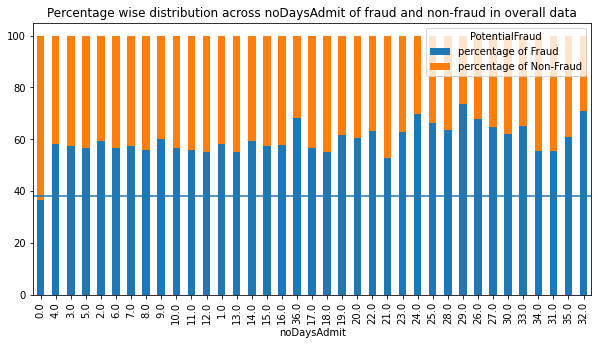

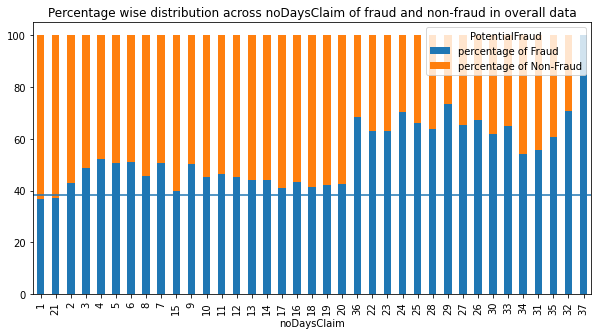

In [ ]:
stackedBarGraph(train,'noDaysAdmit')
stackedBarGraph(train,'noDaysClaim')

In [ ]:
train.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,ClaimMinusAdmitDays,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes,7.0,7,66.0,1.0,1.0,0.0,7,36060,3274
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaT,NaN,0.0,NaT,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932-05-01,NaT,1,1,0,39,310,12,12,1,1,1,0,0,0,0,1,0,0,0,24000,2136,450,200,Yes,0.0,1,77.0,0.0,1.0,1.0,4,24450,2336
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,1913-12-01,NaT,0,1,0,39,230,12,12,1,1,1,0,1,0,0,1,0,0,0,19000,1068,100,20,Yes,13.0,13,95.0,1.0,1.0,0.0,5,19100,1088
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,1922-10-01,NaT,1,1,0,39,600,12,12,0,0,0,0,0,0,0,1,1,0,0,17000,1068,1050,540,Yes,19.0,19,87.0,1.0,1.0,0.0,2,18050,1608
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,1930-07-01,NaT,0,1,0,39,280,12,12,0,1,0,0,1,0,1,1,1,1,0,27000,2136,450,160,Yes,5.0,5,79.0,1.0,1.0,0.0,6,27450,2296


# Feature Engineering

We have analysed all the columns are BeneID , noAdmitDays , noClaimDays , InscClaimAmtReimbursed , Attending Physician , Operating Physician , Claim Diagnisis Codes , Claim Procedure Codes , Provider , Race, PatientRiskIndex , State , County , IPAnnualReimbursementAmt , IPAnnualDeductibleAmt , OPAnnualReimbursementAmt , OPAnnualDeductibleAmt. But there are huge number of categrical variables( Claim Diagnosis Codes , Procedure Codes , Physicians , State , County . We will convert them into numerical by some way.

In [ ]:
#Filling all NA values wih 0
train=train.fillna(0).copy()

In [ ]:
train

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,ClaimMinusAdmitDays,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,0,0,2009-04-12 00:00:00,7866,1068.0,2009-04-18 00:00:00,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,0.0,1943-01-01,0,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes,7.0,7,66.0,1.0,1.0,0.0,7,36060,3274
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,0,0,0,0.0,0,0,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,0,0.0,0.0,0.0,0.0,0.0,0.0,1932-05-01,0,1,1,0,39,310,12,12,1,1,1,0,0,0,0,1,0,0,0,24000,2136,450,200,Yes,0.0,1,77.0,0.0,1.0,1.0,4,24450,2336
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20 00:00:00,45340,1068.0,2009-02-01 00:00:00,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,0,7769.0,5849.0,0.0,0.0,0.0,0.0,1913-12-01,0,0,1,0,39,230,12,12,1,1,1,0,1,0,0,1,0,0,0,19000,1068,100,20,Yes,13.0,13,95.0,1.0,1.0,0.0,5,19100,1088
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,0,2009-10-17 00:00:00,V5789,1068.0,2009-11-04 00:00:00,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,0,9338.0,0.0,0.0,0.0,0.0,0.0,1922-10-01,0,1,1,0,39,600,12,12,0,0,0,0,0,0,0,1,1,0,0,17000,1068,1050,540,Yes,19.0,19,87.0,1.0,1.0,0.0,2,18050,1608
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25 00:00:00,71946,1068.0,2009-10-29 00:00:00,506,71535,71960,4019,V1202,4240,2449,2768,0,0,0,8154.0,0.0,0.0,0.0,0.0,0.0,1930-07-01,0,0,1,0,39,280,12,12,0,1,0,0,1,0,1,1,1,1,0,27000,2136,450,160,Yes,5.0,5,79.0,1.0,1.0,0.0,6,27450,2296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE154147,CLM394122,2009-06-02,2009-06-04,PRV54050,500,PHY317497,0,PHY317497,0,0,0.0,0,0,71698,71941,7862,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1925-01-01,0,0,1,0,23,400,12,12,0,0,0,0,0,0,0,1,1,0,0,0,0,890,120,No,0.0,3,84.0,0.0,1.0,3.0,2,890,120
558207,BENE154687,CLM184358,2009-02-08,2009-02-08,PRV54302,3300,PHY376238,PHY376238,0,0,99639,0.0,0,0,99661,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1927-05-01,0,1,2,0,25,150,12,12,1,0,1,0,0,0,1,1,0,1,0,0,0,4400,220,No,0.0,1,82.0,0.0,1.0,1.0,5,4400,220
558208,BENE157378,CLM460770,2009-07-09,2009-07-29,PRV51577,2100,PHY338096,0,0,0,0,0.0,0,0,5854,7907,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1946-06-01,0,0,1,1,5,200,12,12,1,1,1,0,1,0,1,1,0,0,0,0,0,14240,2810,No,0.0,21,63.0,0.0,1.0,21.0,7,14240,2810
558209,BENE158295,CLM306999,2009-04-16,2009-04-16,PRV53083,10,PHY416646,0,0,0,0,0.0,0,0,42789,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1924-08-01,0,0,1,0,16,490,12,12,0,1,1,1,1,1,1,1,1,1,0,0,0,640,350,No,0.0,1,85.0,0.0,1.0,1.0,9,640,350


Storing this data for future use sothat we don't need to rerun all the cells again for this basic processing

CHANGES DONE SO FAR:

--converted Data columns from string to datetime format(ClaimStartDt,ClaimEndDt,AdmissionDt,DischargeDt,DOB,DOD)

--created column 'noDaysAdmit' ,'noDaysClaim' indicating hospitalisation and claim duration

--created new column for 'age'

--created new column "inOut, whetheralive" indicating wether patient is inpatient or outpatient or he is alive or dead.

--updated all the disease indicator columns with )0 or 1 values only instead of  2 or 1/ Yes or No.

--created new column 'ClaimMinusAdmitDays' which is difference b/w claim and hospitalisation duration.

--created new column 'PatientRiskValue' which sums all the diease indicator columns for all claims.

--created new column 'TotalAnnualReimbursementAmt' which is sum of 'IPAnnualReimbursementAmt' and 'OPAnnualReimbursementAmt'.

--created new column 'TotalAnnualDeductibleAmt' which is sum of 'IPAnnualDeductibleAmt' and 'OPAnnualDeductibleAmt'.

--Replaced all NAN values with 0 in all the columns.


In [ ]:
train.to_csv('/content/drive/MyDrive/AppliedRoots/Project/processed_data.csv')

In [ ]:
len(train[train.PotentialFraud=='Yes'])

212796